<a href="https://colab.research.google.com/github/Bella151305/Bella_Skillfactory/blob/master/Artsy_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import requests
import json
from pprint import pprint
import time

import pandas as pd
import numpy as np
import random
from datetime import datetime

In [ ]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [ ]:
#! pip install pillow --user

In [ ]:
import PIL
from PIL import Image
import os
import cv2

%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%config InlineBackend.figure_format = 'svg'

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.7/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['random', 'datetime']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [ ]:
!pip install -q efficientnet

     |████████████████████████████████| 50 kB 5.6 MB/s 


In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow.keras as keras
import tensorflow.keras.models as M
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Lambda, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
#from keras.utils import to_categorical

from tensorflow.keras.applications.xception import Xception
import efficientnet.tfkeras as efn
from tensorflow.keras.models import Model

print(tf.__version__)
print(keras.__version__)

2.6.0
2.6.0


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Tue Aug 24 17:37:29 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

To enable a high-RAM runtime, select the Runtime > "Change runtime type"
menu, and then select High-RAM in the Runtime shape dropdown. Then, 
re-execute this cell.


In [ ]:
!pip freeze > requirements.txt

In [ ]:
artworks_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Artsy_images/artworks_data_new_cat_norm_size.csv')

# Наши таргеты - 5 категорий

In [ ]:
artworks_data.groupby(['category_new'])['id'].count()

category_new
drawing                   6727
engraving                 6686
gouache and watercolor     832
painting                  2134
photography                754
Name: id, dtype: int64

In [ ]:
artworks_data['id'].count()

17133

In [ ]:
path_norm = '/content/drive/MyDrive/Colab Notebooks/Artsy_images/normalized/'
path_norm_test = '/content/drive/MyDrive/Colab Notebooks/Artsy_images/norm_test/'
path_res = '/content/drive/MyDrive/Colab Notebooks/Artsy_images/resized/'
path_crop = '/content/drive/MyDrive/Colab Notebooks/Artsy_images/cropped/'

In [ ]:
# для проверки ниличия картинок
artworks_data['check_norm_img'] = np.nan

for id in artworks_data['id'].to_list():
  name_inp = path_norm + id + '.jpg'
  if os.path.isfile(name_inp) == True:
    artworks_data.loc[(artworks_data['id']==id), ['check_norm_img']] = 1

In [ ]:
artworks_data.groupby(['check_norm_img'])['id'].count()
#16901

check_norm_img
1.0    16901
Name: id, dtype: int64

In [ ]:
artworks_data['img_nan'] = artworks_data['check_norm_img'].isna()
artworks_data[artworks_data['img_nan']==True]['id'].count()
#232

232

In [ ]:
artworks_data[artworks_data['img_nan']==True].groupby(['category_new'])['id'].count()
# все из тестовой выборки - что-то случилось при переносе

category_new
drawing                   89
engraving                 94
gouache and watercolor    13
painting                  28
photography                8
Name: id, dtype: int64

In [ ]:
artworks_data = artworks_data.dropna(subset=['check_norm_img'], axis=0)

In [ ]:
artworks_data['id'].count()

16901

In [ ]:
artworks_data = artworks_data.drop(['check_norm_img'], axis=1)

In [ ]:
CLASS_NUM = artworks_data['category_new'].nunique()
CLASS_NUM

5

In [ ]:
labels_dict = {'painting': 3, 'engraving': 1, 'drawing': 0,
               'gouache and watercolor': 2, 'photography': 4}

In [ ]:
def label_encoder(cell):
  for k, v in labels_dict.items():
    if cell == k:
      cell = v
  return cell

In [ ]:
artworks_data['cat_le'] = artworks_data['category_new'].apply(label_encoder)

In [ ]:
artworks_data.groupby(['category_new'])['id'].count()

category_new
drawing                   6638
engraving                 6592
gouache and watercolor     819
painting                  2106
photography                746
Name: id, dtype: int64

In [ ]:
artworks_data.groupby(['cat_le'])['id'].count()

cat_le
0    6638
1    6592
2     819
3    2106
4     746
Name: id, dtype: int64

Наша модель будет состоять из 2 частей:
1. Сжатые до 320х320 картинки будут подаваться в кастомную модель свертки или одну из предобученных (с использованием transfer learning).
2. Разбитые на кусочки 320х320 несжатые картинки будут подаваться в неглубокую модель свертки для считывания самой нижнеуровневой информации (четкость линий, контрастность цветов). Для валидационной и тестовой выборки будет вырезаться кусочек 320х320 из середины картинки

# Изучим картинки

In [ ]:
# проработаем логику сбора параметров и сжатия картинок на 3 картинках разных категорий
id_test_list = ['515b7a1ccd4b8ef7fd000797', '515b7bde1b12b0244a000953', '515b7bf9cd4b8ed0b9000271', '515bbbc794714c1d2e0017ca']
artworks_data['for_test'] = artworks_data['id'].apply(lambda x: 1 if x in id_test_list else np.nan)
img_test_data = artworks_data[artworks_data['for_test']==1]
img_test_data

id  ... for_delete
3770  515b7a1ccd4b8ef7fd000797  ...        1.0
3803  515b7bde1b12b0244a000953  ...        1.0
3806  515b7bf9cd4b8ed0b9000271  ...        1.0
5592  515bbbc794714c1d2e0017ca  ...        1.0

[4 rows x 76 columns]

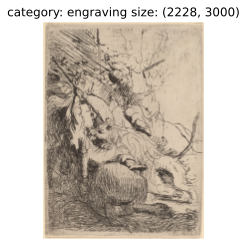

Пример кусочка


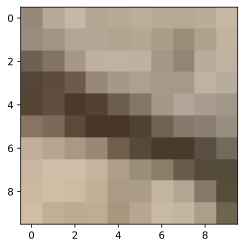

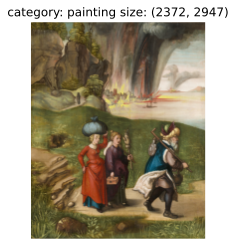

Пример кусочка


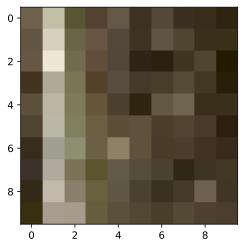

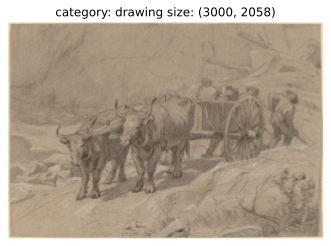

Пример кусочка


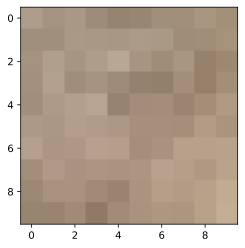

In [ ]:
# Подберем kernel_size
for id in img_test_data['id'].to_list():
  try:
    name_norm = path_norm + id + '.jpg'
  
    img = Image.open(name_norm)
    plt.imshow(img)
    plt.title('category: ' + str(img_test_data[img_test_data['id']==id]['category_new'].values[0]) + ' size: ' + str(img.size))
    plt.axis('off')
    plt.show()

#   The coordinates for the box are (left, upper, right, lower)
    box = (100, 145, 110, 155)
    crop_img = img.crop(box)
    print('Пример кусочка')
    plt.imshow(crop_img)
    plt.show()

    img.close()
  except: continue
# kernel_size=(5,5)

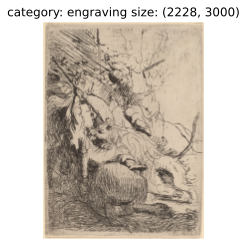

Пример кусочка


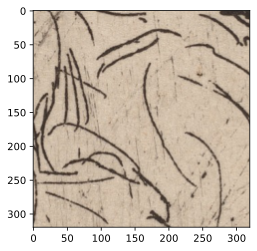

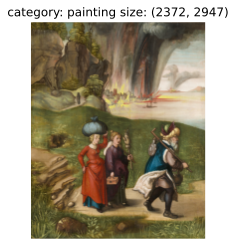

Пример кусочка


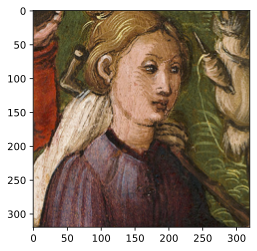

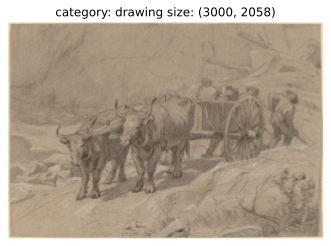

Пример кусочка


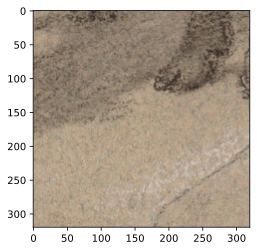

In [ ]:
# в качестве аугментации данных будем разбивать обучающие картинки на кусочки 320х320
# для валидационной и тестовой выборки - вырезать кусочек 320х320 из середины картинки
for id in img_test_data['id'].to_list():
  try:
    name_norm = path_norm + id + '.jpg'
  
    img = Image.open(name_norm)
    plt.imshow(img)
    plt.title('category: ' + str(img_test_data[img_test_data['id']==id]['category_new'].values[0]) + ' size: ' + str(img.size))
    plt.axis('off')
    plt.show()

#   The coordinates for the box are (left, upper, right, lower)
    box = (1000, 1500, 1320, 1820) # 320x320
    crop_img = img.crop(box)
    print('Пример кусочка')
    plt.imshow(crop_img)
    plt.show()

    img.close()
  except: continue

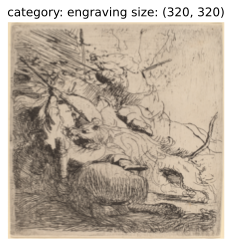

Пример кусочка


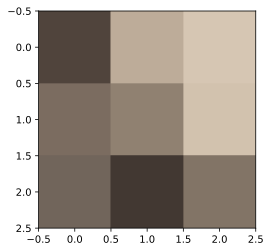

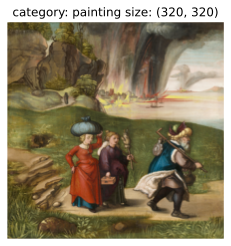

Пример кусочка


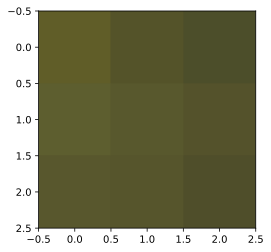

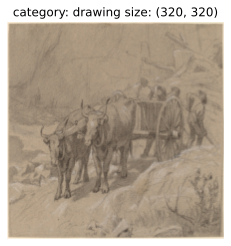

Пример кусочка


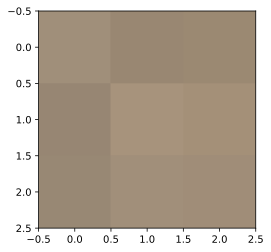

In [ ]:
# Подберем kernel_size для resized
for id in img_test_data['id'].to_list():
  try:
    name_norm = path_norm + id + '.jpg'
  
    img = Image.open(name_norm)
    img_res = img.copy()
    img_res = img_res.resize((320, 320))
    plt.imshow(img_res)
    plt.title('category: ' + str(img_test_data[img_test_data['id']==id]['category_new'].values[0]) + ' size: ' + str(img_res.size))
    plt.axis('off')
    plt.show()

#   The coordinates for the box are (left, upper, right, lower)
    box = (100, 140, 103, 143)
    crop_img = img_res.crop(box)
    print('Пример кусочка')
    plt.imshow(crop_img)
    plt.show()

    img.close()
  except: continue
# kernel_size=(10,10)

Аугментировать будем следующим образом

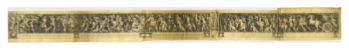

In [ ]:
id = '515bbbc794714c1d2e0017ca'
name_norm = path_norm + id + '.jpg'
  
img = Image.open(name_norm)
plt.imshow(img)
plt.axis('off')
plt.show()

In [ ]:
# сначала картинку отцентрируем
imgwidth, imgheight = img.size
width = 320
height = 320
k_wid = imgwidth//width
x_wid = imgwidth%width/2
k_hgt = imgheight//height
x_hgt = imgheight%height/2
#   The coordinates for the box are (left, upper, right, lower)
box = (x_wid, x_hgt, x_wid+width*k_wid, x_hgt+height*k_hgt)
print(img.size)
print(k_wid)
print(x_wid)
print(k_hgt)
print(x_hgt)
print(box)

(3000, 320)
9
60.0
1
0.0
(60.0, 0.0, 2940.0, 320.0)


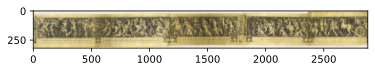

In [ ]:
crop_img = img.crop(box)
plt.imshow(crop_img)
plt.show()

In [ ]:
def crop(img, height, width):
    imgwidth, imgheight = img.size
    for i in range(imgheight//height):
        for j in range(imgwidth//width):
            box = (j*width, i*height, (j+1)*width, (i+1)*height)
            yield img.crop(box)

In [ ]:
imgwidth, imgheight = crop_img.size
k = (imgwidth*imgheight)//(width*height)
print(imgwidth)
print(imgheight)
print(k)

2880
320
9


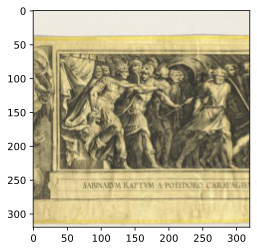

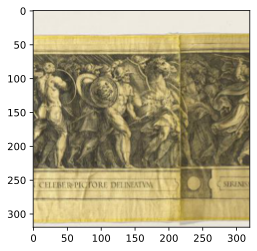

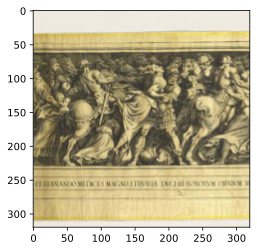

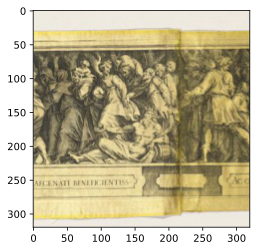

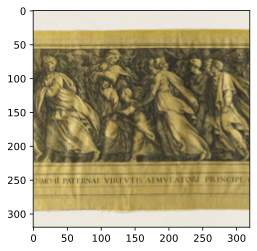

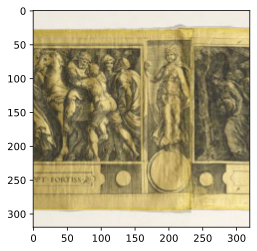

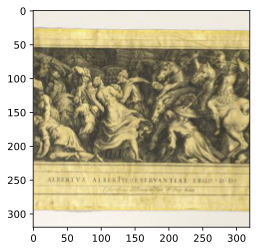

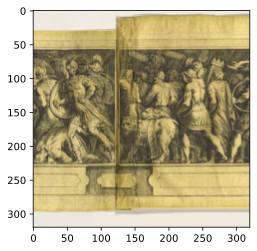

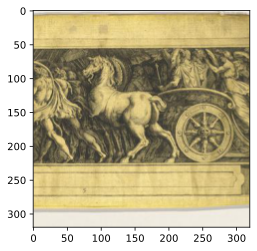

In [ ]:
img = crop_img
for k, piece in enumerate(crop(img, height, width)):
  img_k = Image.new('RGB', (height, width), 255)
  img_k.paste(piece)
  plt.imshow(img_k)
  plt.show()

In [ ]:
img.close()

Для валидационной и тестовой выборки будем вырезать кусочек 320х320 из середины картинки

In [ ]:
id = '515bbbc794714c1d2e0017ca'
name_norm = path_norm + id + '.jpg'
  
img = Image.open(name_norm)

imgwidth, imgheight = img.size
width = 320
height = 320
x_wid = imgwidth//2 - width/2
x_hgt = imgheight//2 - height/2
#   The coordinates for the box are (left, upper, right, lower)
box = (x_wid, x_hgt, x_wid+width, x_hgt+height)
print(img.size)
print(x_wid)
print(x_hgt)
print(box)

(3000, 320)
1340.0
0.0
(1340.0, 0.0, 1660.0, 320.0)


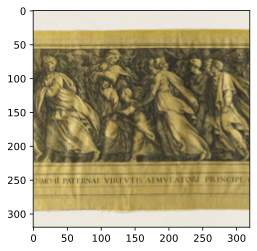

In [ ]:
crop_img = img.crop(box)
plt.imshow(crop_img)
plt.show()

In [ ]:
img.close()

# split данных

## test_data

In [ ]:
test_data = img_test_data[['id', 'category_new', 'normalized_size']]
test_data

id category_new normalized_size
3770  515b7a1ccd4b8ef7fd000797    engraving       2228x3000
3803  515b7bde1b12b0244a000953     painting       2372x2947
3806  515b7bf9cd4b8ed0b9000271      drawing       3000x2058
5592  515bbbc794714c1d2e0017ca    engraving        3000x319

In [ ]:
test_y_train = test_data.category_new.values
test_X_train = test_data.id.values
print(test_y_train)
print(test_X_train)

['engraving' 'painting' 'drawing' 'engraving']
['515b7a1ccd4b8ef7fd000797' '515b7bde1b12b0244a000953'
 '515b7bf9cd4b8ed0b9000271' '515bbbc794714c1d2e0017ca']


In [ ]:
# конвертируем метки в to_categorical
label_encoder = LabelEncoder()
vec_train = label_encoder.fit_transform(test_y_train)
test_y_train_cat = keras.utils.to_categorical(vec_train, dtype='int32')
print(test_y_train_cat.shape, test_X_train.shape)

(4, 3) (4,)


In [ ]:
vec_train

array([1, 2, 0, 1])

In [ ]:
test_X_train

array(['515b7a1ccd4b8ef7fd000797', '515b7bde1b12b0244a000953',
       '515b7bf9cd4b8ed0b9000271', '515bbbc794714c1d2e0017ca'],
      dtype=object)

In [ ]:
test_y_train_cat

array([[0, 1, 0],
       [0, 0, 1],
       [1, 0, 0],
       [0, 1, 0]], dtype=int32)

## тестовый split данных

In [ ]:
artworks_data['id'].count()//4

4225

In [ ]:
artworks_data_target = artworks_data[['id', 'category_new', 'cat_le']]

In [ ]:
artworks_rest, artworks_for_test = train_test_split(artworks_data_target, test_size=0.25, shuffle=True, random_state=RANDOM_SEED)

In [ ]:
print(artworks_for_test['id'].count())
artworks_for_test.groupby(['category_new'])['id'].count()

4226


category_new
drawing                   1667
engraving                 1659
gouache and watercolor     206
painting                   515
photography                179
Name: id, dtype: int64

In [ ]:
artworks_for_test.groupby(['cat_le'])['id'].count()

cat_le
0    1667
1    1659
2     206
3     515
4     179
Name: id, dtype: int64

In [ ]:
train_for_test, val_for_test = train_test_split(artworks_for_test, test_size=0.20, shuffle=True, random_state=RANDOM_SEED)

In [ ]:
print(train_for_test['id'].count())
train_for_test.groupby(['cat_le'])['id'].count()

3380


cat_le
0    1338
1    1330
2     159
3     405
4     148
Name: id, dtype: int64

In [ ]:
print(val_for_test['id'].count())
val_for_test.groupby(['cat_le'])['id'].count()

846


cat_le
0    329
1    329
2     47
3    110
4     31
Name: id, dtype: int64

In [ ]:
# наш таргет
test_y_train = train_for_test.category_new.values
test_y_val = val_for_test.category_new.values

# конвертируем метки в to_categorical
#label_encoder = LabelEncoder()
#vec_train = label_encoder.fit_transform(test_y_train)
#vec_val = label_encoder.fit_transform(test_y_val)
#test_y_train_cat = label_encoder.fit_transform(test_y_train)
#test_y_val_cat = label_encoder.fit_transform(test_y_val)

#test_y_train_cat = keras.utils.to_categorical(vec_train)
#test_y_val_cat = keras.utils.to_categorical(vec_val)

test_y_train_cat = train_for_test.cat_le.values
test_y_val_cat = val_for_test.cat_le.values

print(test_y_train_cat.shape, test_y_val_cat.shape)

# наши параметры = id
test_X_train = train_for_test.id.values
test_X_val = val_for_test.id.values
print(test_X_train.shape, test_X_val.shape)

(3380,) (846,)
(3380,) (846,)


In [ ]:
print(set(test_y_train.tolist()))
print(set(test_y_train_cat.tolist()))
# не совпадает с примерами ниже

{'engraving', 'gouache and watercolor', 'drawing', 'photography', 'painting'}
{0, 1, 2, 3, 4}


In [ ]:
test_y_train[:10]

array(['painting', 'engraving', 'engraving', 'drawing',
       'gouache and watercolor', 'painting', 'engraving', 'painting',
       'engraving', 'drawing'], dtype=object)

In [ ]:
test_y_train_cat[:10]
#array([3, 1, 1, 0, 2, 3, 1, 3, 1, 0])

array([3, 1, 1, 0, 2, 3, 1, 3, 1, 0])

In [ ]:
test_y_train_cat_ker = keras.utils.to_categorical(test_y_train_cat)
test_y_train_cat_ker[:10]

array([[0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.]], dtype=float32)

In [ ]:
print(set(test_y_val.tolist()))
print(set(test_y_val_cat.tolist()))

{'engraving', 'gouache and watercolor', 'drawing', 'photography', 'painting'}
{0, 1, 2, 3, 4}


In [ ]:
test_y_val[:10]

array(['engraving', 'painting', 'drawing', 'drawing', 'drawing',
       'drawing', 'engraving', 'painting', 'drawing', 'engraving'],
      dtype=object)

In [ ]:
test_y_val_cat[:10]
#array([1, 3, 0, 0, 0, 0, 1, 3, 0, 1])

array([1, 3, 0, 0, 0, 0, 1, 3, 0, 1])

In [ ]:
test_y_val_cat_ker = keras.utils.to_categorical(test_y_val_cat)
test_y_val_cat_ker[:10]

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.]], dtype=float32)

## split данных

In [ ]:
# split данных
artworks_data_target = artworks_data[['id', 'category_new', 'cat_le']]
artworks_train, artworks_test = train_test_split(artworks_data_target, test_size=0.20, shuffle=True, random_state=RANDOM_SEED)
artworks_train, artworks_val = train_test_split(artworks_train, test_size=0.25, shuffle=True, random_state=RANDOM_SEED)

In [ ]:
# наш таргет
y_train_cat = artworks_train.cat_le.values
y_val_cat = artworks_val.cat_le.values
y_test_cat = artworks_test.cat_le.values

y_train = artworks_train.category_new.values
y_val = artworks_val.category_new.values
y_test = artworks_test.category_new.values
print(y_train_cat.shape, y_val_cat.shape, y_test_cat.shape)

# наши параметры = id
X_train = artworks_train.id.values
X_val = artworks_val.id.values
X_test = artworks_test.id.values
print(X_train.shape, X_val.shape, X_test.shape)

(10140,) (3380,) (3381,)
(10140,) (3380,) (3381,)


In [ ]:
y_train_num = artworks_train.cat_le.values
y_val_num = artworks_val.cat_le.values
y_test_num = artworks_test.cat_le.values

In [ ]:
# конвертируем метки в to_categorical
y_train_cat = keras.utils.to_categorical(y_train_cat)
y_val_cat = keras.utils.to_categorical(y_val_cat)
y_test_cat = keras.utils.to_categorical(y_test_cat)

print(y_train_cat.shape, y_val_cat.shape, y_test_cat.shape)

(10140, 5) (3380, 5) (3381, 5)


In [ ]:
artworks_val.category_new.values[:10]

array(['drawing', 'drawing', 'engraving', 'engraving',
       'gouache and watercolor', 'drawing', 'drawing', 'engraving',
       'engraving', 'engraving'], dtype=object)

In [ ]:
artworks_val.cat_le.values[:10]

array([0, 0, 1, 1, 2, 0, 0, 1, 1, 1])

In [ ]:
y_val_cat[:10]

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]], dtype=float32)

# resize 
Сжатые до 320х320 картинки будут подаваться в кастомную модель свертки или одну из предобученных (с использованием transfer learning) - УЖЕ СЖАЛИ

In [ ]:
# !!! УЖЕ СЖАЛИ
size = (320, 320)

def get_res_image_array(data):
    images_array = []
    for id in data:
        image = cv2.imread(path_norm + str(id) + '.jpg')
        assert(image is not None)
        res_image = cv2.resize(image, size).copy()
        res_image = res_image.astype('float32') / 255 - 0.5 # нормируем данные
        images_array.append(res_image)
    images_array = np.array(images_array)
    print('images shape', images_array.shape, 'dtype', images_array.dtype)
    return(images_array)

### test dataset

In [ ]:
# тестовый датасет
paths_val = [path_res + id + '.jpg' for id in test_X_val]
paths_train = [path_res + id + '.jpg' for id in test_X_train]
labels_val = test_y_val_cat
labels_train = test_y_train_cat

In [ ]:
for i in paths_val[:3]:
  print(i)
print(len(paths_val))

/content/drive/MyDrive/Colab Notebooks/Artsy_images/resized/516cb9b8078b321478000f43.jpg
/content/drive/MyDrive/Colab Notebooks/Artsy_images/resized/4fcf9efcc3cc4b000100181b.jpg
/content/drive/MyDrive/Colab Notebooks/Artsy_images/resized/515ba47ccd4b8ef7fd001470.jpg
846


In [ ]:
labels_val[:3]

array([1, 3, 0])

In [ ]:
test_val_data = tf.data.Dataset.from_tensor_slices((paths_val, labels_val))
test_val_data.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [ ]:
def read_image(image_path, label):
  image = tf.image.decode_jpeg(tf.io.read_file(image_path), channels=3)
  return image, label

test_val_data = test_val_data.map(read_image)
test_val_data.element_spec

(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [ ]:
test_val_data.element_spec[1]

TensorSpec(shape=(), dtype=tf.int64, name=None)

In [ ]:
def process_image(image, label):
  image = tf.image.resize(image, [224, 224]) # для transfer learning !!!
  #image = tf.reshape(image, (320, 320, 3)) # для небольших моделей !!!
  #image = image / 255 - 0.5 # нормируем данные - в самой модели
  #tf.ensure_shape(image, [320, 320])
  return image, label

test_val_data = test_val_data.map(process_image)
test_val_data.element_spec

(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [ ]:
test_val_data.batch(32).element_spec

(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int64, name=None))

In [ ]:
#for images, label in test_val_data.take(1):
#  print('images.shape: ', images.shape)
#  print('labels.shape: ', labels.shape)

images.shape:  (320, 320, 3)
labels.shape:  (857, 5)


In [ ]:
test_train_data = tf.data.Dataset.from_tensor_slices((paths_train, labels_train))

test_train_data = test_train_data.map(read_image)

test_train_data = test_train_data.map(process_image)

test_train_data.batch(32).element_spec

(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int64, name=None))

### total dataset

In [ ]:
#y_train_cat, y_val_cat, y_test_cat
#X_train, X_val, X_test

paths_val_res = [path_res + id + '.jpg' for id in X_val]
paths_train_res = [path_res + id + '.jpg' for id in X_train]
labels_val = y_val_cat
labels_train = y_train_cat

In [ ]:
def read_image(image_path, label):
  image = tf.image.decode_jpeg(tf.io.read_file(image_path), channels=3)
  return image, label

def process_image(image, label):
  image = tf.image.resize(image, [224, 224]) # для transfer learning !!!
  #image = tf.reshape(image, (320, 320, 3)) # для небольших моделей !!!
  return image, label

In [ ]:
val_data_res = tf.data.Dataset.from_tensor_slices((paths_val_res, labels_val))

val_data_res = val_data_res.map(read_image)

val_data_res = val_data_res.map(process_image)
val_data_res.element_spec

(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(5,), dtype=tf.float32, name=None))

In [ ]:
val_data_res.batch(32).element_spec

(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))

In [ ]:
train_data_res = tf.data.Dataset.from_tensor_slices((paths_train_res, labels_train))

train_data_res = train_data_res.map(read_image)

train_data_res = train_data_res.map(process_image)
train_data_res.element_spec

(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(5,), dtype=tf.float32, name=None))

In [ ]:
train_data_res.batch(32).element_spec

(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))

# crop
Для валидационной и тестовой выборки будет вырезаться кусочек 320х320 из середины картинки - УЖЕ КРОПНУЛИ

In [ ]:
# !!! УЖЕ КРОПНУЛИ
side = 320

def get_crop_image_array(data):
    images_array = []
    for id in data:
        image = cv2.imread(path_norm + str(id) + '.jpg')
        assert(image is not None)
        imgheight, imgwidth, channels = image.shape
        x_wid = int(imgwidth//2) - int(side/2)
        x_hgt = int(imgheight//2) - int(side/2)
#        box = (x_wid, x_hgt, x_wid+width, x_hgt+height)
        crop_image = image[x_hgt:x_hgt+side, x_wid:x_wid+side].copy()
        crop_image = crop_image.astype('float32') / 255 - 0.5 # нормируем данные
        images_array.append(crop_image)
    images_array = np.array(images_array)
    print('images shape', images_array.shape, 'dtype', images_array.dtype)
    return(images_array)

### test dataset

In [ ]:
paths_val_crop = [path_crop + id + '.jpg' for id in test_X_val]
paths_train_crop = [path_crop + id + '.jpg' for id in test_X_train]
labels_val_crop = test_y_val_cat
labels_train_crop = test_y_train_cat

In [ ]:
def read_image(image_path, label):
  image = tf.image.decode_jpeg(tf.io.read_file(image_path), channels=3)
  return image, label

In [ ]:
def process_image(image, label):
  image = tf.reshape(image, (320, 320, 3))
  return image, label

In [ ]:
val_data_crop = tf.data.Dataset.from_tensor_slices((paths_val_crop, labels_val_crop))

val_data_crop = val_data_crop.map(read_image)

val_data_crop = val_data_crop.map(process_image)

val_data_crop.batch(32).element_spec

(TensorSpec(shape=(None, 320, 320, 3), dtype=tf.uint8, name=None),
 TensorSpec(shape=(None,), dtype=tf.int64, name=None))

In [ ]:
train_data_crop = tf.data.Dataset.from_tensor_slices((paths_train_crop, labels_train_crop))

train_data_crop = train_data_crop.map(read_image)

train_data_crop = train_data_crop.map(process_image)

train_data_crop.batch(32).element_spec

(TensorSpec(shape=(None, 320, 320, 3), dtype=tf.uint8, name=None),
 TensorSpec(shape=(None,), dtype=tf.int64, name=None))

### total dataset

In [ ]:
#y_train_cat, y_val_cat, y_test_cat
#X_train, X_val, X_test

paths_val_crop = [path_crop + id + '.jpg' for id in X_val]
paths_train_crop = [path_crop + id + '.jpg' for id in X_train]
labels_val = y_val_cat
labels_train = y_train_cat

In [ ]:
def read_image(image_path, label):
  image = tf.image.decode_jpeg(tf.io.read_file(image_path), channels=3)
  return image, label

def process_image(image, label):
  image = tf.reshape(image, (320, 320, 3))
  return image, label

In [ ]:
val_data_crop = tf.data.Dataset.from_tensor_slices((paths_val_crop, labels_val))

val_data_crop = val_data_crop.map(read_image)

val_data_crop = val_data_crop.map(process_image)
val_data_crop.element_spec

(TensorSpec(shape=(320, 320, 3), dtype=tf.uint8, name=None),
 TensorSpec(shape=(5,), dtype=tf.float32, name=None))

In [ ]:
val_data_crop.batch(32).element_spec

(TensorSpec(shape=(None, 320, 320, 3), dtype=tf.uint8, name=None),
 TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))

In [ ]:
train_data_crop = tf.data.Dataset.from_tensor_slices((paths_train_crop, labels_train))

train_data_crop = train_data_crop.map(read_image)

train_data_crop = train_data_crop.map(process_image)
train_data_crop.element_spec

(TensorSpec(shape=(320, 320, 3), dtype=tf.uint8, name=None),
 TensorSpec(shape=(5,), dtype=tf.float32, name=None))

In [ ]:
train_data_crop.batch(32).element_spec

(TensorSpec(shape=(None, 320, 320, 3), dtype=tf.uint8, name=None),
 TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))

# slice via tf.
В качестве аугментации данных будем разбивать обучающие картинки на кусочки 320х320

### проработка

In [ ]:
side = 320
def get_sliced_image_array(data):
    images_array = []

    for id in data:
        image = cv2.imread(path_norm + str(id) + '.jpg')
        assert(image is not None)
        imgheight, imgwidth, channels = image.shape
        k_wid = int(imgwidth//side)
        x_wid = int(imgwidth%side/2)
        k_hgt = int(imgheight//side)
        x_hgt = int(imgheight%side/2)
        crop_image = image[x_hgt:x_hgt+side*k_hgt, x_wid:x_wid+side*k_wid].copy()
        
        imghgt, imgwid, chan = crop_image.shape
        #pieces = []
        for hgt in range(int(imghgt//side)):
          for wid in range(int(imgwid//side)):
            piece = crop_image[hgt*side:(hgt+1)*side, wid*side:(wid+1)*side]
            piece = piece.astype('float32') / 255 - 0.5 # нормируем данные
            images_array.append(piece)

        #images_array.append(pieces)
    images_array = np.array(images_array)
    print('images shape', images_array.shape, 'dtype', images_array.dtype)
    return(images_array)

In [ ]:
images_sliced_test_data = get_sliced_image_array(test_X_train)
# 54+54+63=171
# НАПРЯМУЮ НЕ БУДЕТ РАБОТАТЬ, ТОЛЬКО В ВИДЕ АУГМЕНТАЦИИ

images shape (171, 320, 320, 3) dtype float32


In [ ]:
for id in img_test_data['id'].to_list():
    name_norm = path_norm + id + '.jpg'
    image = tf.image.decode_jpeg(tf.io.read_file(name_norm), channels=3)
    print(tf.shape(image))

tf.Tensor([3000 2228    3], shape=(3,), dtype=int32)
tf.Tensor([2947 2372    3], shape=(3,), dtype=int32)
tf.Tensor([2058 3000    3], shape=(3,), dtype=int32)
tf.Tensor([ 320 3000    3], shape=(3,), dtype=int32)


In [ ]:
side = 320
id = '515bbbc794714c1d2e0017ca'
name_norm = path_norm + id + '.jpg'

image = tf.image.decode_jpeg(tf.io.read_file(name_norm), channels=3)
image = image / 255 - 0.5 # нормируем данные
print(tf.shape(image))
imgheight = tf.shape(image)[0]
imgwidth = tf.shape(image)[1]
print(imgheight)
print(imgwidth)

tf.Tensor([ 320 3000    3], shape=(3,), dtype=int32)
tf.Tensor(320, shape=(), dtype=int32)
tf.Tensor(3000, shape=(), dtype=int32)


In [ ]:
offset_height = int(imgheight%side/2)
offset_width = int(imgwidth%side/2)
print(offset_height)
print(offset_width)
target_height = int(imgheight - offset_height*2)
target_width = int(imgwidth - offset_width*2)
print(target_height)
print(target_width)

0
60
320
2880


In [ ]:
## image, offset_height, offset_width, target_height, target_width
## The top-left corner of the bounding box is at offset_height, offset_width in image, 
## and the lower-right corner is at offset_height + target_height, offset_width + target_width
cropped_image = tf.image.crop_to_bounding_box(
    image, offset_height, offset_width, target_height, target_width)
print(tf.shape(cropped_image))

imgheight_new = tf.shape(cropped_image)[0]
imgwidth_new = tf.shape(cropped_image)[1]
k = (imgheight_new*imgwidth_new)//(side*side)
print(k)

tf.Tensor([ 320 2880    3], shape=(3,), dtype=int32)
tf.Tensor(9, shape=(), dtype=int32)


In [ ]:
# offset_height, offset_width, target_height, target_width
for hgt in range(imgheight_new//side):
  for wid in range(imgwidth_new//side):
    print(int(hgt*side), int(wid*side), side, side)
# shape=(320, 1600, 3), dtype=float32
# ValueError: width must be >= target + offset

0 0 320 320
0 320 320 320
0 640 320 320
0 960 320 320
0 1280 320 320
0 1600 320 320
0 1920 320 320
0 2240 320 320
0 2560 320 320


In [ ]:
piece_count = 0
for hgt in range(imgheight_new//side):
  for wid in range(imgwidth_new//side):
    #piece = crop_image[hgt*side:(hgt+1)*side, wid*side:(wid+1)*side]
## The top-left corner of the bounding box is at offset_height, offset_width in image, 
## and the lower-right corner is at offset_height + target_height, offset_width + target_width
    piece = tf.image.crop_to_bounding_box(
        cropped_image, int(hgt*side), int(wid*side), side, side)
    piece_count += 1
    print(piece)
print(piece_count)

tf.Tensor(
[[[0.4372549  0.42156863 0.37843138]
  [0.4372549  0.42156863 0.37843138]
  [0.4372549  0.42156863 0.37843138]
  ...
  [0.43333334 0.41764706 0.3745098 ]
  [0.43333334 0.41764706 0.3745098 ]
  [0.43333334 0.41764706 0.3745098 ]]

 [[0.4372549  0.42156863 0.37843138]
  [0.4372549  0.42156863 0.37843138]
  [0.4372549  0.42156863 0.37843138]
  ...
  [0.43333334 0.41764706 0.3745098 ]
  [0.43333334 0.41764706 0.3745098 ]
  [0.43333334 0.41764706 0.3745098 ]]

 [[0.4372549  0.42156863 0.37843138]
  [0.4372549  0.42156863 0.37843138]
  [0.4372549  0.42156863 0.37843138]
  ...
  [0.43333334 0.41764706 0.3745098 ]
  [0.43333334 0.41764706 0.3745098 ]
  [0.43333334 0.41764706 0.3745098 ]]

 ...

 [[0.4764706  0.44117647 0.44509804]
  [0.48431373 0.4490196  0.45294118]
  [0.4764706  0.44117647 0.44509804]
  ...
  [0.42156863 0.4137255  0.35490197]
  [0.43333334 0.4254902  0.36666667]
  [0.42941177 0.42156863 0.3627451 ]]

 [[0.40588236 0.39803922 0.34705883]
  [0.41764706 0.40980393 0

In [ ]:
###

In [ ]:
def sliced_image(image):
  side = 320
  
  image = image / 255 - 0.5 # нормируем данные
  imgheight = tf.shape(image)[0]
  imgwidth = tf.shape(image)[1]

  offset_height = int(imgheight%side/2)
  offset_width = int(imgwidth%side/2)
  target_height = int(imgheight - offset_height*2)
  target_width = int(imgwidth - offset_width*2)

  image = tf.image.crop_to_bounding_box(
      image, offset_height, offset_width, target_height, target_width)

  imgheight_new = tf.shape(image)[0]
  imgwidth_new = tf.shape(image)[1]
  k = (imgheight_new*imgwidth_new)//(side*side)

  for hgt in range(imgheight_new//side):
    for wid in range(imgwidth_new//side):
      piece = tf.image.crop_to_bounding_box(
          image, int(hgt*side), int(wid*side), side, side)
      yield piece

In [ ]:
def image_gen(image):
  ds_series = tf.data.Dataset.from_generator(
    sliced_image, 
    #output_types=(tf.float32, tf.float32),
    #output_shapes=((None,), (3,))) 
    output_types=(tf.float32),
    output_shapes=((None,))) 
    #output_shapes=((None, 320, 320, 3))
  #return ds_series[0], ds_series[1] # TypeError: 'FlatMapDataset' object is not subscriptable
  #return ds_series[:,0], ds_series[:,1] # TypeError: 'FlatMapDataset' object is not subscriptable
  return ds_series

In [ ]:
#paths_train_crop
#labels_train_crop
#test_train_data_crop

test_train_data_crop = tf.data.Dataset.from_tensor_slices((paths_train_crop, labels_train_crop))
test_train_data_crop.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(5,), dtype=tf.float32, name=None))

In [ ]:
def read_image(image_path, label):
  image = tf.image.decode_jpeg(tf.io.read_file(image_path), channels=3)
  return image, label

test_train_data_crop = test_train_data_crop.map(read_image)
test_train_data_crop.element_spec

(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None),
 TensorSpec(shape=(5,), dtype=tf.float32, name=None))

In [ ]:
def process_image(image, label):
  return image_gen(image), label

In [ ]:
test_train_data_crop = test_train_data_crop.map(process_image)

test_train_data_crop.batch(32).element_spec
#DatasetSpec((TensorSpec(shape=(None,), dtype=tf.float32, name=None), TensorSpec(shape=(3,), dtype=tf.float32, name=None)), TensorShape([None]))

Instructions for updating:
Use output_signature instead
Instructions for updating:
Use output_signature instead


(DatasetSpec(TensorSpec(shape=(None,), dtype=tf.float32, name=None), TensorShape([None])),
 TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))

### разбивка: test dataset

In [ ]:
#test_X_val
#test_y_val_cat

In [ ]:
#paths_val_crop = [path_crop + id + '.jpg' for id in test_X_val]
#labels_val_crop = test_y_val_cat

In [ ]:
#def make_crops_val(image, label):
#  crop_size = 320
#  crop_rows = test_X_val.shape[0]
#  crop_cols = 1
#  crops = tf.TensorArray(tf.uint8, size=crop_rows*crop_cols, element_shape=(crop_size, crop_size, 3))
  #return crops.stack(), tf.fill((crop_rows*crop_cols,), label)
#  return crops, tf.fill((crop_rows*crop_cols,), label)

In [ ]:
#test_X_train
#test_y_train_cat

In [ ]:
paths_train_crop = [path_norm + id + '.jpg' for id in test_X_train]
labels_train_crop = test_y_train_cat

train_data_crop = tf.data.Dataset.from_tensor_slices((paths_train_crop, labels_train_crop))
train_data_crop.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [ ]:
def read_image(image_path, label):
  image = tf.image.decode_jpeg(tf.io.read_file(image_path), channels=3)
  return image, label

train_data_crop = train_data_crop.map(read_image)
train_data_crop.element_spec

(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [ ]:
@tf.function
def make_crops(image, label):
  crop_size = 320
  total_height = tf.shape(image)[0]
  total_width = tf.shape(image)[1]
  crop_rows = total_height // crop_size
  crop_cols = total_width // crop_size
  #tf.print('Splitting img with size', total_height, 'x', total_width, 'to', crop_rows, 'x', crop_cols, 'crops')
  crops = tf.TensorArray(tf.uint8, size=crop_rows*crop_cols, element_shape=(crop_size, crop_size, 3))
  # https://www.tensorflow.org/guide/function#accumulating_values_in_a_loop
  for i in range(crop_rows):
    for j in range(crop_cols):
      crop = image[crop_size*i:crop_size*(i+1), crop_size*j:crop_size*(j+1)]
      crops.write(i*crop_rows + j, crop)
  return crops.stack(), tf.fill((crop_rows*crop_cols,), label)
  #return crops.stack(), tf.tile((crop_rows*crop_cols,), label)

In [ ]:
train_data_crop = train_data_crop.map(make_crops).unbatch()
#for img, label in test_train_data_crop.take(100):
#  print(img.shape, label.shape)

In [ ]:
train_data_crop.element_spec

(TensorSpec(shape=(320, 320, 3), dtype=tf.uint8, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [ ]:
paths_val_crop = [path_crop + id + '.jpg' for id in test_X_val]
labels_val_crop = test_y_val_cat

val_data_crop = tf.data.Dataset.from_tensor_slices((paths_val_crop, labels_val_crop))

val_data_crop = val_data_crop.map(read_image)

val_data_crop = val_data_crop.map(make_crops).unbatch()

val_data_crop.batch(32).element_spec

(TensorSpec(shape=(None, 320, 320, 3), dtype=tf.uint8, name=None),
 TensorSpec(shape=(None,), dtype=tf.int64, name=None))

In [ ]:
val_data_crop.element_spec

(TensorSpec(shape=(320, 320, 3), dtype=tf.uint8, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

# Строим сверточные сети

In [ ]:
# рисуем график accuracy
def plot_history(history):
    plt.figure(figsize=(10,5))
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    #plt.figure()
    plt.figure(figsize=(10,5))
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

In [ ]:
K.clear_session()

In [ ]:
# В сетап выношу основные настройки, так удобней их перебирать в дальнейшем

CLASS_NUM            = CLASS_NUM
IMG_SIZE             = 320
IMG_SIZE_TL          = 224
IMG_CHANNELS         = 3
input_shape          = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)
input_shape_tl       = (IMG_SIZE_TL, IMG_SIZE_TL, IMG_CHANNELS)

## model_slice_crop
Эта модель нужна для определения техники создания произведения: четкости линий, контрастности цветов. Для нее мы взяли оригинальные картинки, разбитые на куски 320х320 без изменения качества (!!! пока есть только кроп из середины).

Здесь нам не нужен маленький фильтр 3х3 - возьмем 5х5. Также нам не нужна глубокая архитектура, так как нам не нужно общее видение куска изображения - только информация нижнего уровня.

In [ ]:
def conv_model_slice_crop():
    model = M.Sequential()
    # keras.layers.Lambda(lambda x: x/255)

    model.add(L.Lambda(lambda x: x/255, input_shape=input_shape))
    model.add(L.Conv2D(16, kernel_size=(5,5), strides=1, activation='relu', padding='same', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(L.Conv2D(16, kernel_size=(5,5), strides=1, activation='relu', padding='same'))
    model.add(BatchNormalization())
    
    model.add(L.MaxPooling2D(pool_size=(2,2)))
    model.add(L.Dropout(0.2))
    
    model.add(L.Conv2D(32, kernel_size=(5,5), strides=1, activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(L.Conv2D(32, kernel_size=(5,5), strides=1, activation='relu', padding='same'))
    model.add(BatchNormalization())
    
    model.add(L.Flatten())
    
    model.add(L.Dense(128, activation='relu'))
    model.add(L.Dropout(0.25))
    model.add(BatchNormalization())
    #model.add(L.Dense(CLASS_NUM, activation='relu'))
    model.add(L.Dense(CLASS_NUM, activation='softmax'))
    return model

model_slice_crop = conv_model_slice_crop()
model_slice_crop.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 320, 320, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 320, 320, 16)      1216      
_________________________________________________________________
batch_normalization (BatchNo (None, 320, 320, 16)      64        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 320, 320, 16)      6416      
_________________________________________________________________
batch_normalization_1 (Batch (None, 320, 320, 16)      64        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 160, 160, 16)      0         
_________________________________________________________________
dropout (Dropout)            (None, 160, 160, 16)      0

In [ ]:
# без аугментации
optimizer_slice_crop = tf.keras.optimizers.Adam(0.005)
model_slice_crop.compile(loss='categorical_crossentropy',optimizer=optimizer_slice_crop, metrics=['accuracy'])
# keras.losses.SparseCategoricalCrossentropy() - для аугментации

checkpoint_slice_crop = ModelCheckpoint('/content/best_model_slice_crop.hdf5', monitor=['val_accuracy'], verbose=1, mode='max')
# save_best_only=True => Can save best model only with %s available; TypeError: unhashable type: 'list'
earlystop_slice_crop = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True,)
callbacks_list_slice_crop = [checkpoint_slice_crop, earlystop_slice_crop]

In [ ]:
# для аугментации
optimizer_slice_crop = tf.keras.optimizers.Adam(0.005)
model_slice_crop.compile(loss=keras.losses.SparseCategoricalCrossentropy(),optimizer=optimizer_slice_crop, metrics=['accuracy'])

checkpoint_slice_crop = ModelCheckpoint('/content/best_model_slice_crop.hdf5', monitor=['val_accuracy'], verbose=1, mode='max')
# save_best_only=True => Can save best model only with %s available; TypeError: unhashable type: 'list'
earlystop_slice_crop = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True,)
callbacks_list_slice_crop = [checkpoint_slice_crop, earlystop_slice_crop]

In [ ]:
#val_data_crop
#train_data_crop

In [ ]:
history_slice_crop = model_slice_crop.fit(train_data_crop.batch(100),
                                          epochs = 10,
                                          validation_data = val_data_crop.batch(100),
                                          callbacks=callbacks_list_slice_crop
                                          )

Epoch 1/10
2463/2463 [==============================] - 1854s 745ms/step - loss: 1.2933 - accuracy: 0.4104 - val_loss: 1.3276 - val_accuracy: 0.3889

Epoch 00001: saving model to /content/best_model_slice_crop.hdf5
Epoch 2/10
2463/2463 [==============================] - 845s 343ms/step - loss: 1.2819 - accuracy: 0.4141 - val_loss: 1.3317 - val_accuracy: 0.3889

Epoch 00002: saving model to /content/best_model_slice_crop.hdf5
Epoch 3/10
2463/2463 [==============================] - 853s 346ms/step - loss: 1.2777 - accuracy: 0.4145 - val_loss: 1.3346 - val_accuracy: 0.3889

Epoch 00003: saving model to /content/best_model_slice_crop.hdf5
Epoch 4/10
2463/2463 [==============================] - 852s 346ms/step - loss: 1.2767 - accuracy: 0.4202 - val_loss: 1.3286 - val_accuracy: 0.3889

Epoch 00004: saving model to /content/best_model_slice_crop.hdf5
Epoch 5/10
2463/2463 [==============================] - 852s 346ms/step - loss: 1.2759 - accuracy: 0.4202 - val_loss: 1.3235 - val_accuracy: 0.

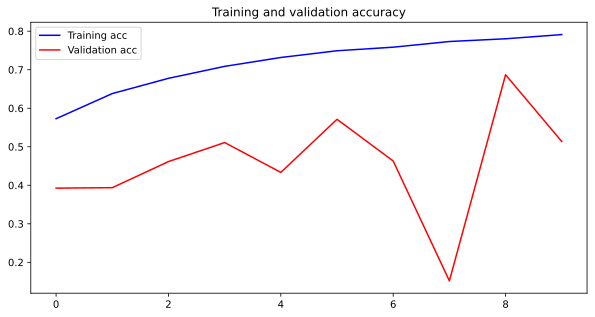

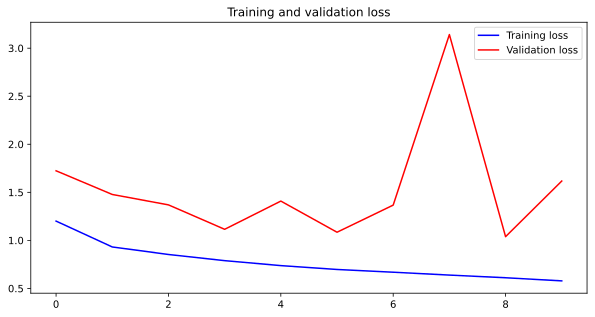

In [ ]:
plot_history(history_slice_crop)

In [ ]:
model_slice_crop.load_weights('/content/best_model_slice_crop_relu_10.hdf5')
model_slice_crop.save('/content/final_slice_crop.hdf5')

In [ ]:
model_slice_crop.load_weights('/content/best_model_slice_crop_sm_9.hdf5')
model_slice_crop.save('/content/final_slice_crop.hdf5')

In [ ]:
#model_slice_crop.load_weights('/content/best_model_slice_crop_2epoch_2.hdf5')

In [ ]:
#model_slice_crop.weights

In [ ]:
evaluate_crop = model_slice_crop.evaluate(val_data_crop.batch(100))
print("Accuracy: %.2f%%" % (evaluate_crop[1]*100))
# 54.08% is best result for relu
# 68.70% is best result for softmax

34/34 [==============================] - 6s 159ms/step - loss: 1.0385 - accuracy: 0.6870
Accuracy: 68.70%


In [ ]:
predict_crop = model_slice_crop.predict(val_data_crop.batch(100))

In [ ]:
predict_crop.shape

(3380, 5)

In [ ]:
predict_crop

array([[9.8366404e-01, 1.4215942e-03, 3.8871078e-03, 2.8390766e-03,
        8.1882775e-03],
       [9.5573330e-01, 2.3672699e-04, 1.5349884e-02, 7.0786984e-03,
        2.1601390e-02],
       [8.1592017e-01, 1.7935115e-01, 2.4028854e-03, 3.3580654e-04,
        1.9900415e-03],
       ...,
       [7.6602809e-02, 9.2313826e-01, 4.2426524e-05, 1.0443321e-04,
        1.1205576e-04],
       [9.9378514e-01, 6.3822011e-04, 1.9208749e-03, 1.9858299e-04,
        3.4573146e-03],
       [9.6537912e-01, 7.9654753e-03, 8.9299362e-03, 5.2441023e-03,
        1.2481215e-02]], dtype=float32)

In [ ]:
predict_crop_argmax = np.argmax(predict_crop, axis=-1) #multiple categories
# Возвращает индексы максимальных значений вдоль оси
predict_crop_argmax[:10]

array([0, 0, 0, 1, 0, 0, 0, 1, 1, 1])

In [ ]:
predict_crop_argmax.shape

(3380,)

In [ ]:
crop_val_results = pd.DataFrame({'id': X_val, 'cat': y_val_num
                                , 'cat_predict': predict_crop_argmax
                                , 'category_new': y_val}
                                , columns=['id', 'cat', 'cat_predict', 'category_new'])

In [ ]:
def label_decoder(cell):
  for k, v in labels_dict.items():
    if cell == v:
      cell = k
  return cell

In [ ]:
crop_val_results['category_new_pridict'] = crop_val_results['cat_predict'].apply(label_decoder)

In [ ]:
crop_val_results['check'] = crop_val_results['cat'] == crop_val_results['cat_predict']

In [ ]:
crop_val_results.head()

id  cat  ...  category_new_pridict  check
0  516cac3eb83d23b4db000b80    0  ...               drawing   True
1  515b148e9562c86fb800095d    0  ...               drawing   True
2  515d5083769659e1fb004235    1  ...               drawing  False
3  515b4ad2223afaab8f0014da    1  ...             engraving   True
4  516df517b31e2b22700009f2    2  ...               drawing  False

[5 rows x 6 columns]

In [ ]:
crop_val_results.groupby(['check'])['id'].count()

check
False    1058
True     2322
Name: id, dtype: int64

In [ ]:
round(crop_val_results.groupby(['check'])['id'].count()[1]/crop_val_results['id'].count()*100, 2)

68.7

In [ ]:
crop_val_results.to_csv('crop_val_results_total_softmax.csv', index=False)

При обучении на аугментированных данных 6 эпох показали абсолютно идентичные результаты - обучались на одних и тех же картинках?

loss: 1.6094 - accuracy: 0.4044

## model_res
Эта модель нужна для определения композиции произведения: расположение цветовых пятен, в том числе закрашенных и незакрашенных частей. Для нее мы взяли сжатые до 320х320 картинки.

Поэтому нам не нужен маленький фильтр 3х3, возьмем 10х10.

In [ ]:
def conv_model_res():
    model = M.Sequential()

    model.add(L.Lambda(lambda x: x/255, input_shape=input_shape))
    model.add(L.Convolution2D(32, (10, 10), input_shape=input_shape, activation='relu', padding='same',))
    model.add(L.BatchNormalization())
    model.add(L.Convolution2D(32, (10, 10), activation='relu', padding='same',))
    model.add(L.BatchNormalization())

    model.add(L.MaxPooling2D(pool_size=(2,2)))
    model.add(L.Dropout(0.2))

    model.add(L.Convolution2D(64, (10, 10), activation='relu', padding='same',))
    model.add(L.BatchNormalization())
    model.add(L.Convolution2D(64, (10, 10), activation='relu', padding='same',))
    model.add(L.BatchNormalization())

    model.add(L.MaxPooling2D(pool_size=(10, 10)))
    model.add(L.Dropout(0.3))

    model.add(L.Convolution2D(128, (10, 10), activation='relu', padding='same',))
    model.add(L.BatchNormalization())
    model.add(L.Convolution2D(128, (10, 10), activation='relu', padding='same',))
    model.add(L.BatchNormalization())

    model.add(L.MaxPooling2D(pool_size=(2,2)))
    model.add(L.Dropout(0.3))

    model.add(L.Flatten())
    model.add(L.Dense(256, activation='relu'))
    model.add(L.Dropout(0.25))
    #model.add(L.Dense(CLASS_NUM, activation='relu'))
    model.add(L.Dense(CLASS_NUM, activation='softmax'))
    return model

model_res = conv_model_res()
model_res.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 320, 320, 3)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 320, 320, 32)      9632      
_________________________________________________________________
batch_normalization_5 (Batch (None, 320, 320, 32)      128       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 320, 320, 32)      102432    
_________________________________________________________________
batch_normalization_6 (Batch (None, 320, 320, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 160, 160, 32)      0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 160, 160, 32)     

In [ ]:
optimizer_res = tf.keras.optimizers.Adam(0.001)
model_res.compile(loss='categorical_crossentropy',optimizer=optimizer_res, metrics=['accuracy'])

checkpoint_res = ModelCheckpoint('/content/best_model_res.hdf5', monitor=['val_accuracy'], verbose=1, mode='max')
earlystop_res = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True,)
callbacks_res = [checkpoint_res, earlystop_res]

In [ ]:
#test_val_data
#test_train_data

#val_data_res
#train_data_res

In [ ]:
history_res = model_res.fit(train_data_res.batch(100),
                            epochs = 10,
                            validation_data = val_data_res.batch(100),
                            callbacks=callbacks_res
                            )

Epoch 1/10
102/102 [==============================] - 170s 2s/step - loss: 0.9207 - accuracy: 0.6290 - val_loss: 3.4255 - val_accuracy: 0.1633

Epoch 00001: saving model to /content/best_model_res.hdf5
Epoch 2/10
102/102 [==============================] - 168s 2s/step - loss: 0.8442 - accuracy: 0.6747 - val_loss: 2.5774 - val_accuracy: 0.2441

Epoch 00002: saving model to /content/best_model_res.hdf5
Epoch 3/10
102/102 [==============================] - 168s 2s/step - loss: 0.8111 - accuracy: 0.6912 - val_loss: 1.1256 - val_accuracy: 0.5562

Epoch 00003: saving model to /content/best_model_res.hdf5
Epoch 4/10
102/102 [==============================] - 168s 2s/step - loss: 0.7857 - accuracy: 0.7035 - val_loss: 0.9236 - val_accuracy: 0.5873

Epoch 00004: saving model to /content/best_model_res.hdf5
Epoch 5/10
102/102 [==============================] - 168s 2s/step - loss: 0.7655 - accuracy: 0.7140 - val_loss: 0.7730 - val_accuracy: 0.6825

Epoch 00005: saving model to /content/best_model

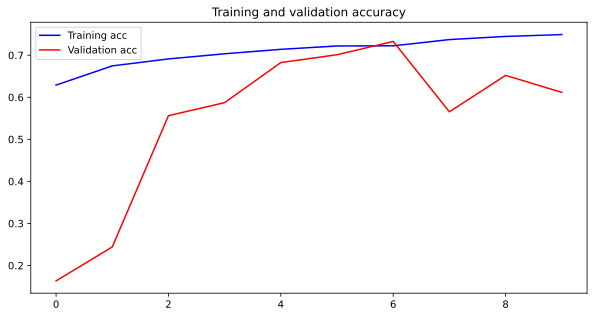

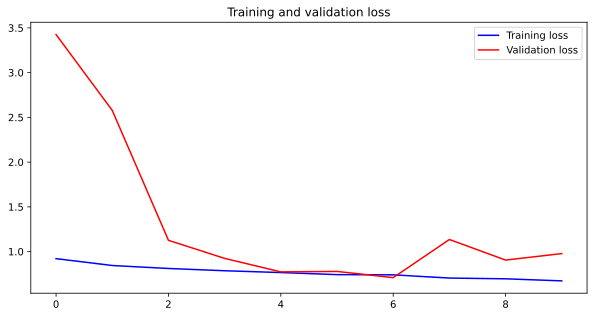

In [ ]:
plot_history(history_res)

При Adam(0.0001) обучение закончилось к 3 эпохе, а валидационный loss - на 2 эпохе, а валидационный accuracy не менялся на протяжении всех 6 эпох (patience=5).

Adam(0.005), loss='categorical_crossentropy' и softmax привели к резкому переобучению модели.

После изменения скорости обучения на 0.001 переобучение наступило только после 7 эпохи.

In [ ]:
model_res.load_weights('/content/best_model_res_sm_7.hdf5')
model_res.save('/content/final_res.hdf5')

In [ ]:
evaluate_res = model_res.evaluate(val_data_res.batch(100))
print("Accuracy: %.2f%%" % (evaluate_res[1]*100))

34/34 [==============================] - 7s 196ms/step - loss: 0.7088 - accuracy: 0.7328
Accuracy: 73.28%


In [ ]:
predict_res = model_res.predict(val_data_res.batch(100))

In [ ]:
predict_res.shape

(3380, 5)

In [ ]:
predict_res

array([[7.06758261e-01, 1.83821857e-01, 1.01044513e-01, 2.05047050e-04,
        8.17035418e-03],
       [7.62404084e-01, 1.10647984e-01, 1.18021309e-01, 4.92679654e-04,
        8.43393523e-03],
       [6.45169467e-02, 9.35126245e-01, 3.45993874e-04, 5.36955133e-11,
        1.08373169e-05],
       ...,
       [9.74601582e-02, 9.01528120e-01, 9.72595008e-04, 5.27049238e-10,
        3.90681344e-05],
       [5.21347463e-01, 4.14357841e-01, 5.73892258e-02, 3.42912099e-05,
        6.87127374e-03],
       [8.24040592e-01, 1.15717269e-01, 5.91462404e-02, 2.82213296e-06,
        1.09310402e-03]], dtype=float32)

In [ ]:
predict_res_argmax = np.argmax(predict_res, axis=-1) #multiple categories
# Возвращает индексы максимальных значений вдоль оси
predict_res_argmax[:10]

array([0, 0, 1, 1, 0, 0, 0, 1, 0, 1])

In [ ]:
predict_res_argmax.shape

(3380,)

In [ ]:
res_val_results = pd.DataFrame({'id': X_val, 'cat': y_val_num
                                , 'cat_predict': predict_res_argmax
                                , 'category_new': y_val}
                                , columns=['id', 'cat', 'cat_predict', 'category_new'])

In [ ]:
def label_decoder(cell):
  for k, v in labels_dict.items():
    if cell == v:
      cell = k
  return cell

In [ ]:
res_val_results['category_new_pridict'] = res_val_results['cat_predict'].apply(label_decoder)

In [ ]:
res_val_results['check'] = res_val_results['cat'] == res_val_results['cat_predict']

In [ ]:
res_val_results.head()

id  cat  ...  category_new_pridict  check
0  516cac3eb83d23b4db000b80    0  ...               drawing   True
1  515b148e9562c86fb800095d    0  ...               drawing   True
2  515d5083769659e1fb004235    1  ...             engraving   True
3  515b4ad2223afaab8f0014da    1  ...             engraving   True
4  516df517b31e2b22700009f2    2  ...               drawing  False

[5 rows x 6 columns]

In [ ]:
res_val_results.groupby(['check'])['id'].count()

check
False     903
True     2477
Name: id, dtype: int64

In [ ]:
round(res_val_results.groupby(['check'])['id'].count()[1]/res_val_results['id'].count()*100, 2)

73.28

In [ ]:
res_val_results.to_csv('res_val_results_total_softmax.csv', index=False)

## blend

In [ ]:
# Пока что 50/50, планируется что slice_crop модель будет давать лучие результаты после аугментации
# predict_crop (total, without slices) = 68.07%; predict_res (total) = 73.28%
blend_evaluate = (evaluate_crop[1] + evaluate_res[1])/2
#blend_evaluate = evaluate_crop[1]*0,9 + evaluate_res[1]*0,1

In [ ]:
print("Accuracy: %.2f%%" % (blend_evaluate*100))

Accuracy: 70.99%


In [ ]:
blend_predict = (model_slice_crop.predict(val_data_crop.batch(100)) + model_res.predict(val_data_res.batch(100))) / 2

In [ ]:
blend_predict_argmax = np.argmax(blend_predict, axis=-1) #multiple categories

blend_predict_results = pd.DataFrame({'id': X_val, 'cat': y_val_num
                                , 'cat_predict': blend_predict_argmax
                                , 'category_new': y_val}
                                , columns=['id', 'cat', 'cat_predict', 'category_new'])

blend_predict_results['category_new_pridict'] = blend_predict_results['cat_predict'].apply(label_decoder)
blend_predict_results['check'] = blend_predict_results['cat'] == blend_predict_results['cat_predict']
blend_predict_results.head()

id  cat  ...  category_new_pridict  check
0  516cac3eb83d23b4db000b80    0  ...               drawing   True
1  515b148e9562c86fb800095d    0  ...               drawing   True
2  515d5083769659e1fb004235    1  ...             engraving   True
3  515b4ad2223afaab8f0014da    1  ...             engraving   True
4  516df517b31e2b22700009f2    2  ...               drawing  False

[5 rows x 6 columns]

In [ ]:
blend_predict_results.groupby(['check'])['id'].count()

check
False     917
True     2463
Name: id, dtype: int64

In [ ]:
round(blend_predict_results.groupby(['check'])['id'].count()[1]/blend_predict_results['id'].count()*100, 2)

72.87

In [ ]:
blend_predict_results.to_csv('blend_results_total_softmax.csv', index=False)

## transfer learning

In [ ]:
# Загружаем предобученную сеть
tl_model = efn.EfficientNetB6(weights='imagenet', include_top=False, input_shape=input_shape_tl)

165527552/165527152 [==============================] - 3s 0us/step


In [ ]:
tl_model.summary()

Model: "efficientnet-b6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 112, 112, 56) 1512        input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 112, 112, 56) 224         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 112, 112, 56) 0           stem_bn[0][0]                    
____________________________________________________________________________________

In [ ]:
# сначала тренируем только голову
tl_model.trainable = False

In [ ]:
# Устанавливаем новую "голову" (head)
x = tl_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.25)(x)
#tl_pridicts = Dense(CLASS_NUM, activation='relu')(x)
tl_pridicts = Dense(CLASS_NUM, activation='softmax')(x)
# не забываем изменить размер картинок !!!

In [ ]:
optimizer_tl = tf.keras.optimizers.Adam(0.001)

model = Model(inputs=tl_model.input, outputs=tl_pridicts)
model.compile(loss='categorical_crossentropy', optimizer=optimizer_tl, metrics=["accuracy"])

checkpoint_tl = ModelCheckpoint('/content/best_model_tl.hdf5', monitor=['val_accuracy'], verbose=1, mode='max')
#save_best_only=True,
earlystop_tl = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True,)
callbacks_tl = [checkpoint_tl, earlystop_tl]

In [ ]:
#test_val_data
#test_train_data

#val_data_res
#train_data_res

In [ ]:
history_tl = model.fit(train_data_res.batch(10),
                      epochs = 10,
                      validation_data = val_data_res.batch(10),
                      callbacks=callbacks_tl
                      )

Epoch 1/10
1014/1014 [==============================] - 110s 95ms/step - loss: 1.8147 - accuracy: 0.3490 - val_loss: 1.3279 - val_accuracy: 0.3920

Epoch 00001: saving model to /content/best_model_tl.hdf5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/10
1014/1014 [==============================] - 93s 92ms/step - loss: 1.7390 - accuracy: 0.3551 - val_loss: 1.2985 - val_accuracy: 0.3947

Epoch 00002: saving model to /content/best_model_tl.hdf5
Epoch 3/10
1014/1014 [==============================] - 113s 111ms/step - loss: 1.6875 - accuracy: 0.3673 - val_loss: 1.2976 - val_accuracy: 0.3914

Epoch 00003: saving model to /content/best_model_tl.hdf5
Epoch 4/10
1014/1014 [==============================] - 112s 111ms/step - loss: 1.6513 - accuracy: 0.3679 - val_loss: 1.2822 - val_accuracy: 0.3926

Epoch 00004: saving model to /content/best_model_tl.hdf5
Epoch 5/10
1014/1014 [==============================] - 113s 111ms/step - loss: 1.6163 - accuracy: 0.3730 - val_loss: 1.2817 - val_accuracy: 0.3855

Epoch 00005: saving model to /content/best_model_tl.hdf5
Epoch 6/10
1014/1014 [==============================] - 113s 111ms/step - loss: 1.6000 - accuracy: 0.3723 - val_loss: 1.2938 - val_accuracy: 0.3914

Epoch 00006: saving model to 

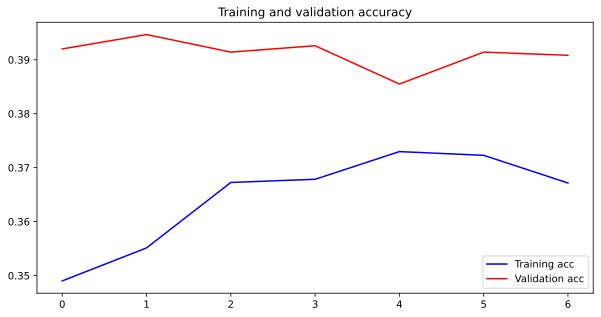

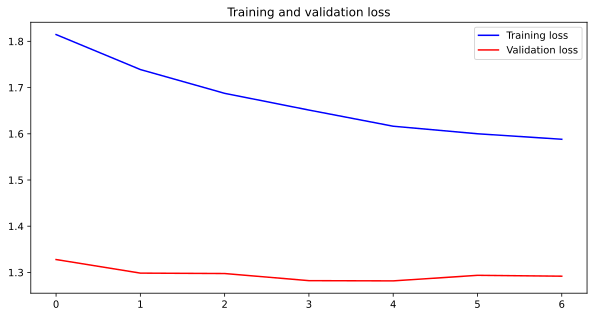

In [ ]:
plot_history(history_tl)

На тестовом датасете при:
- optimizers.Adam(0.005) - переобучилась сразу
- optimizers.Adam(0.001) - тоже переобучилась сразу, но с лучшей метрикой

На полном датасете loss='categorical_crossentropy' и softmax дали нам процесс обучения, хоть и затухающий.

In [ ]:
model.load_weights('/content/best_model_tl_sm_s1_6.hdf5')
model.save('/content/final_tl_step1.hdf5')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [ ]:
evaluate_tl = model.evaluate(val_data_res.batch(100))
print("Accuracy: %.2f%%" % (evaluate_tl[1]*100))

34/34 [==============================] - 16s 449ms/step - loss: 1.2938 - accuracy: 0.3914
Accuracy: 39.14%


In [ ]:
# приступим к fine-tuning
tl_model.trainable = True

fine_tune_at = len(tl_model.layers)//2
for layer in tl_model.layers[:fine_tune_at]:
  layer.trainable =  False
len(tl_model.trainable_variables)

291

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(0.0001), metrics=["accuracy"])

In [ ]:
history_tl = model.fit(train_data_res.batch(10),
                      epochs = 10,
                      validation_data = val_data_res.batch(10),
                      callbacks=callbacks_tl
                      )

Epoch 1/10
1014/1014 [==============================] - 204s 184ms/step - loss: 1.3315 - accuracy: 0.4553 - val_loss: 1.2665 - val_accuracy: 0.4766

Epoch 00001: saving model to /content/best_model_tl.hdf5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/10
1014/1014 [==============================] - 183s 181ms/step - loss: 1.2283 - accuracy: 0.4927 - val_loss: 0.9911 - val_accuracy: 0.5882

Epoch 00002: saving model to /content/best_model_tl.hdf5
Epoch 3/10
1014/1014 [==============================] - 183s 180ms/step - loss: 1.1781 - accuracy: 0.5107 - val_loss: 1.0894 - val_accuracy: 0.6257

Epoch 00003: saving model to /content/best_model_tl.hdf5
Epoch 4/10
1014/1014 [==============================] - 183s 181ms/step - loss: 1.1320 - accuracy: 0.5243 - val_loss: 0.9817 - val_accuracy: 0.6246

Epoch 00004: saving model to /content/best_model_tl.hdf5
Epoch 5/10
1014/1014 [==============================] - 183s 180ms/step - loss: 1.1060 - accuracy: 0.5402 - val_loss: 0.9043 - val_accuracy: 0.6337

Epoch 00005: saving model to /content/best_model_tl.hdf5
Epoch 6/10
1014/1014 [==============================] - 183s 180ms/step - loss: 1.0817 - accuracy: 0.5547 - val_loss: 0.9244 - val_accuracy: 0.6249

Epoch 00006: saving model t

При обучении на всех данных получаем ResourceExhaustedError.

На тестовой выборке - та же проблема. Скорее всего, дело в размере картинки (320х320) и batch_size. Сделаем IMG_SIZE = 224 и batch_size = 10

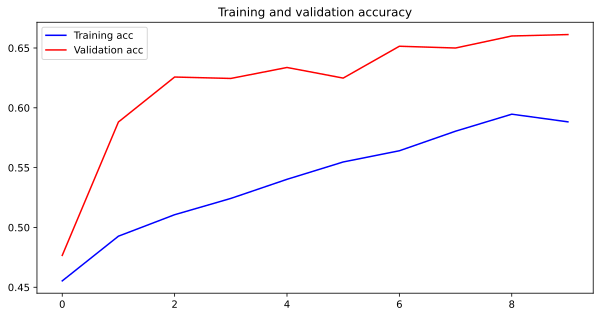

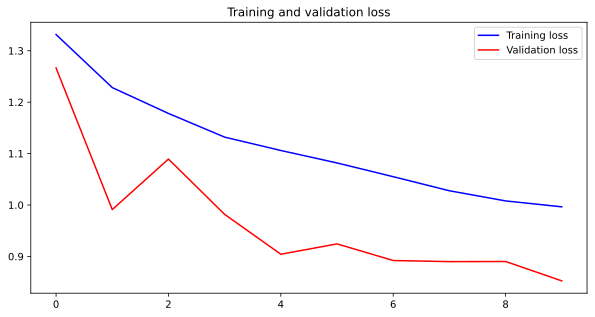

In [ ]:
plot_history(history_tl)

Обучение на тестовом датасете наблюдается на протяжении всех 10 эпох

In [ ]:
model.load_weights('/content/best_model_tl_sm_s2_10.hdf5')
model.save('/content/final_tl_step2.hdf5')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [ ]:
evaluate_tl = model.evaluate(val_data_res.batch(10))
print("Accuracy: %.2f%%" % (evaluate_tl[1]*100))
# тестовый датасет 37.94%

338/338 [==============================] - 23s 68ms/step - loss: 0.8524 - accuracy: 0.6612
Accuracy: 66.12%


In [ ]:
tl_model.trainable = True

model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(0.0001), metrics=["accuracy"])

In [ ]:
history_tl = model.fit(train_data_res.batch(10),
                      epochs = 10,
                      validation_data = val_data_res.batch(10),
                      callbacks=callbacks_tl
                      )

Epoch 1/10
1014/1014 [==============================] - 384s 358ms/step - loss: 0.6971 - accuracy: 0.7373 - val_loss: 2.3527 - val_accuracy: 0.3917

Epoch 00001: saving model to /content/best_model_tl.hdf5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/10
1014/1014 [==============================] - 340s 336ms/step - loss: 0.4242 - accuracy: 0.8488 - val_loss: 0.4445 - val_accuracy: 0.8544

Epoch 00002: saving model to /content/best_model_tl.hdf5
Epoch 3/10
1014/1014 [==============================] - 360s 355ms/step - loss: 0.2623 - accuracy: 0.9091 - val_loss: 0.4969 - val_accuracy: 0.8675

Epoch 00003: saving model to /content/best_model_tl.hdf5
Epoch 4/10
1014/1014 [==============================] - 340s 336ms/step - loss: 0.1560 - accuracy: 0.9441 - val_loss: 0.5269 - val_accuracy: 0.8675

Epoch 00004: saving model to /content/best_model_tl.hdf5
Epoch 5/10
1014/1014 [==============================] - 341s 336ms/step - loss: 0.1140 - accuracy: 0.9619 - val_loss: 0.5959 - val_accuracy: 0.8666

Epoch 00005: saving model to /content/best_model_tl.hdf5
Epoch 6/10
1014/1014 [==============================] - 339s 335ms/step - loss: 0.0807 - accuracy: 0.9712 - val_loss: 0.6474 - val_accuracy: 0.8654

Epoch 00006: saving model t

На тестовом датасете обучение началось только с 5 эпохи

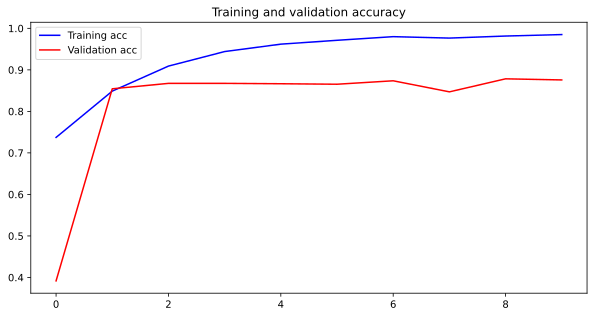

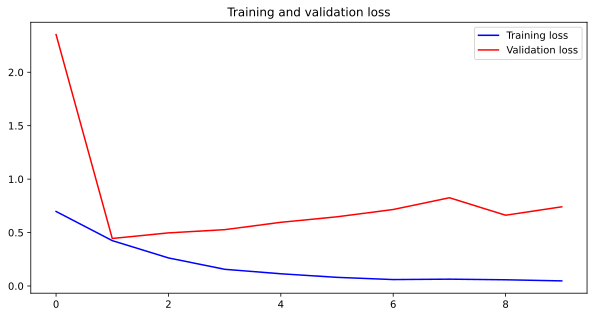

In [ ]:
plot_history(history_tl)

На тестовом датасете обучение выглядит более последовательным. Графики начали сходиться. Но метрика ухудшилась.

Поптобуем на полном датасете.

In [ ]:
model.load_weights('/content/best_model_tl_sm_s3_9.hdf5')
model.save('/content/final_tl_step3.hdf5')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [ ]:
evaluate_tl = model.evaluate(val_data_res.batch(10))
print("Accuracy: %.2f%%" % (evaluate_tl[1]*100))

338/338 [==============================] - 23s 68ms/step - loss: 0.6621 - accuracy: 0.8784
Accuracy: 87.84%


In [ ]:
predict_tl = model.predict(val_data_res.batch(10))

In [ ]:
predict_tl.shape

(3380, 5)

In [ ]:
predict_tl

array([[9.5529842e-01, 4.4696502e-02, 4.9976725e-06, 3.2556130e-08,
        8.5537415e-08],
       [9.9441779e-01, 2.9702979e-04, 5.2729184e-03, 1.1843722e-05,
        4.1377459e-07],
       [7.8516314e-05, 9.9992144e-01, 2.8818223e-09, 1.3260232e-11,
        1.3422930e-12],
       ...,
       [4.5093045e-01, 2.8148448e-02, 5.1910293e-01, 6.0674774e-06,
        1.8121045e-03],
       [1.0000000e+00, 3.5751205e-10, 5.3358072e-08, 4.2597696e-11,
        4.9875188e-09],
       [9.9982685e-01, 1.5457245e-04, 1.8587501e-05, 1.2224129e-08,
        2.4034737e-08]], dtype=float32)

In [ ]:
predict_tl_argmax = np.argmax(predict_tl, axis=-1) #multiple categories
# Возвращает индексы максимальных значений вдоль оси
predict_tl_argmax[:10]

array([0, 0, 1, 1, 2, 0, 0, 1, 1, 1])

In [ ]:
predict_tl_argmax.shape

(3380,)

In [ ]:
tl_val_results = pd.DataFrame({'id': X_val, 'cat': y_val_num
                                , 'cat_predict': predict_tl_argmax
                                , 'category_new': y_val}
                                , columns=['id', 'cat', 'cat_predict', 'category_new'])

In [ ]:
def label_decoder(cell):
  for k, v in labels_dict.items():
    if cell == v:
      cell = k
  return cell

In [ ]:
tl_val_results['category_new_pridict'] = tl_val_results['cat_predict'].apply(label_decoder)

In [ ]:
tl_val_results['check'] = tl_val_results['cat'] == tl_val_results['cat_predict']

In [ ]:
tl_val_results.head()

id  cat  ...    category_new_pridict check
0  516cac3eb83d23b4db000b80    0  ...                 drawing  True
1  515b148e9562c86fb800095d    0  ...                 drawing  True
2  515d5083769659e1fb004235    1  ...               engraving  True
3  515b4ad2223afaab8f0014da    1  ...               engraving  True
4  516df517b31e2b22700009f2    2  ...  gouache and watercolor  True

[5 rows x 6 columns]

In [ ]:
tl_val_results.groupby(['check'])['id'].count()

check
False     411
True     2969
Name: id, dtype: int64

In [ ]:
round(tl_val_results.groupby(['check'])['id'].count()[1]/tl_val_results['id'].count()*100, 2)

87.84

In [ ]:
tl_val_results.to_csv('tl_val_results_total_softmax.csv', index=False)

# Анализ результатов

## test dataset
Датасет: 4226 картинок (без аугментации)


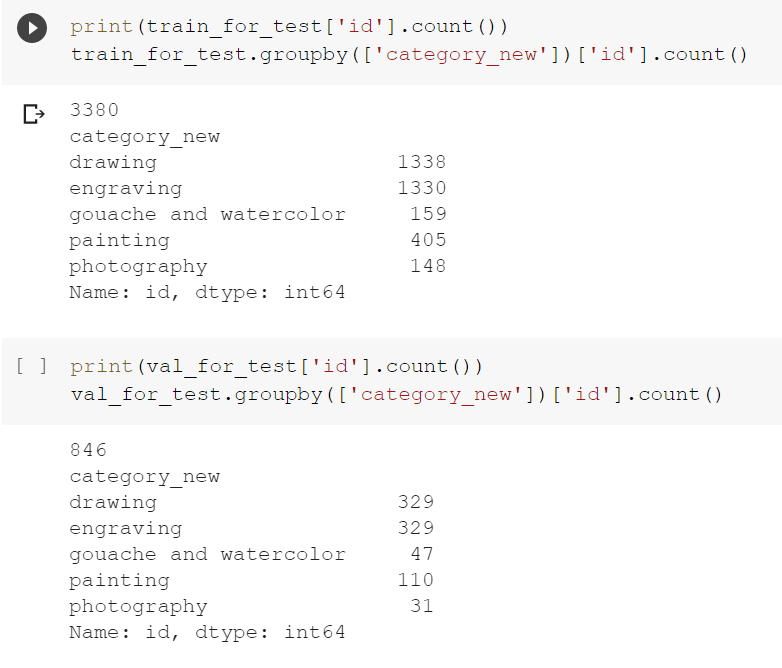

conv_model_res:
- Adam(0.0001)
- patience=10
- epochs = 50 (25/50)
- batch(100)

Закончила обучение на 15 epoch:
 - val_accuracy: 59.46% (best_model) - почему-то затирается

 val_accuracy по итогу = 43.62%

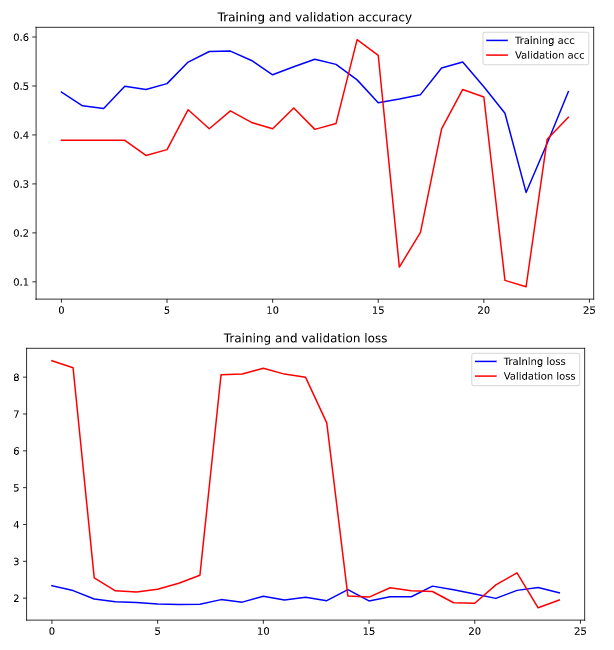

In [ ]:
res_val_results = pd.read_csv('/content/res_val_results.csv')

In [ ]:
round(res_val_results.groupby(['check'])['id'].count()[1]/res_val_results['id'].count()*100, 2)

43.62

In [ ]:
res_val_results.head()

id  cat  ...  check category_new_predict
0  516cb9b8078b321478000f43    1  ...  False              drawing
1  4fcf9efcc3cc4b000100181b    3  ...   True             painting
2  515ba47ccd4b8ef7fd001470    0  ...  False             painting
3  515b67cfcd4b8ed25f0002e7    0  ...   True              drawing
4  516cc456b31e2b838100031a    0  ...   True              drawing

[5 rows x 6 columns]

In [ ]:
res_val_results.groupby(['check'])['id'].count()

check
False    477
True     369
Name: id, dtype: int64

In [ ]:
res_val_results.groupby(['category_new', 'check'])['id'].count()

category_new            check
drawing                 False     15
                        True     314
engraving               False    327
                        True       2
gouache and watercolor  False     47
painting                False     57
                        True      53
photography             False     31
Name: id, dtype: int64

In [ ]:
res_val_results[res_val_results['check']==False].groupby(['category_new', 'category_new_predict'])['id'].count()

category_new            category_new_predict
drawing                 engraving                 4
                        painting                 11
engraving               drawing                 325
                        painting                  2
gouache and watercolor  drawing                  41
                        engraving                 3
                        painting                  3
painting                drawing                  46
                        engraving                 7
                        photography               4
photography             drawing                  16
                        engraving                 1
                        painting                 14
Name: id, dtype: int64

conv_model_slice_crop (только кроп из середины - без аугментации):
- Adam(0.0001)
- patience=10
- epochs = 50 (25/50)
- batch(100)

Закончила обучение на 11 epoch

 val_accuracy по итогу = 32.98%

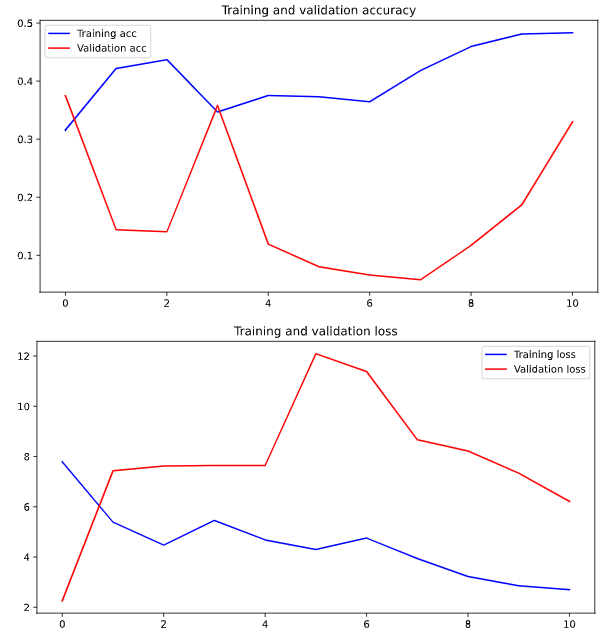

In [ ]:
crop_val_results = pd.read_csv('/content/crop_val_results.csv')

In [ ]:
crop_val_results.groupby(['category_new', 'check'])['id'].count()

category_new            check
drawing                 False     92
                        True     237
engraving               False    321
                        True       8
gouache and watercolor  False     37
                        True      10
painting                False    106
                        True       4
photography             False     11
                        True      20
Name: id, dtype: int64

In [ ]:
crop_val_results[crop_val_results['check']==False].groupby(['category_new', 'category_new_predict'])['id'].count()

category_new            category_new_predict  
drawing                 engraving                   3
                        gouache and watercolor     49
                        painting                    3
                        photography                37
engraving               drawing                   259
                        gouache and watercolor     19
                        painting                    5
                        photography                38
gouache and watercolor  drawing                    26
                        photography                11
painting                drawing                    23
                        engraving                   1
                        gouache and watercolor     42
                        photography                40
photography             drawing                     4
                        gouache and watercolor      4
                        painting                    3
Name: id, dtype: int64

## total dataset
Датасет: 16901 картинка (без аугментации)

(10140, 5) (3380, 5) (3381, 5)

In [ ]:
artworks_data.groupby(['category_new'])['id'].count()

category_new
drawing                   6727
engraving                 6686
gouache and watercolor     832
painting                  2134
photography                754
Name: id, dtype: int64

### conv_model_res

Эта модель нужна для определения композиции произведения: расположение цветовых пятен, в том числе закрашенных и незакрашенных частей.

- Adam(0.001)
- patience=5
- epochs = 10
- batch(100)

- CLASS_NUM activation='softmax'
- loss='categorical_crossentropy'

- best_model: 7
- val_accuracy: 73.28%

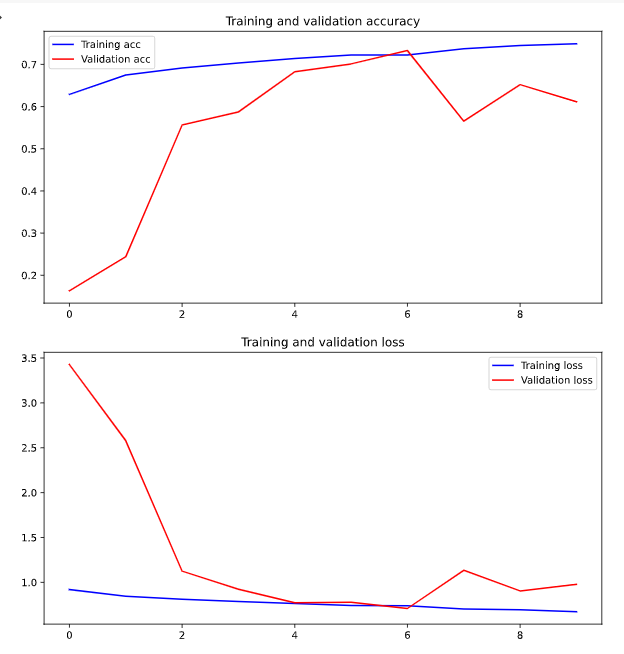

Постепенное обучение модели (скорость изменили с 0.005 на 0.001) - хороший признак. Наилучший результат был достигнут к 7 эпохе. После этого начались скачки показателей.

В нашем датасете достаточно неравномерное распределение по классам. Это обстоятельство затрудняет обучение.

In [ ]:
res_val_results = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Artsy_images/res_val_results_total_softmax.csv')
round(res_val_results.groupby(['check'])['id'].count()[1]/res_val_results['id'].count()*100, 2)

73.28

In [ ]:
# посмотрим количество правдиво и ложно угаданных картинок
res_val_results.groupby(['check'])['id'].count()

check
False     903
True     2477
Name: id, dtype: int64

In [ ]:
# посмотрим количество правдиво и ложно угаданных категорий
res_val_results.groupby(['category_new', 'check'])['id'].count()

category_new            check
drawing                 False     237
                        True     1087
engraving               False     328
                        True     1002
gouache and watercolor  False     166
painting                False      21
                        True      388
photography             False     151
Name: id, dtype: int64

Модель совсем не смогла определить как класс фотографии и гуаши с акварелями. Остальное определяется неплохо.

In [ ]:
# посмотрим с чем модель путает неправильно угаданные категории
res_val_results[res_val_results['check']==False].groupby(['category_new', 'category_new_pridict'])['id'].count()

category_new            category_new_pridict
drawing                 engraving               187
                        painting                 50
engraving               drawing                 318
                        painting                 10
gouache and watercolor  drawing                 117
                        engraving                16
                        painting                 33
painting                drawing                  20
                        engraving                 1
photography             drawing                  35
                        engraving                11
                        painting                105
Name: id, dtype: int64

Модель путает:
1. Рисунки с Гравюрами - они в основном черно-белые, основной момент - четкость линий, но данная модель создана считывать цветовые пятна. Однако, гравюры чаще всего полностью заполнены линиями, а на рисунках много пустот. Интересно посмотреть что из них определяется как картина.
2. Фотографии с рисунками и гравюрами - та же проблема. Однако, фотография в большинстве случаях была определена как картина. Композиционно они вполне могут быть схожи. Изучим примеры.
3. Гуашь и акварель композиционно и по цветовым пятнам схожа с раскрашенными рисунками и гравюрами.

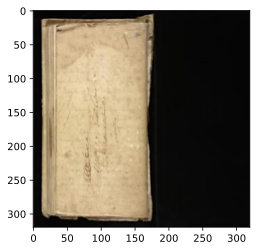

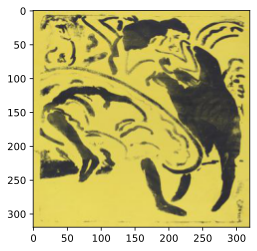

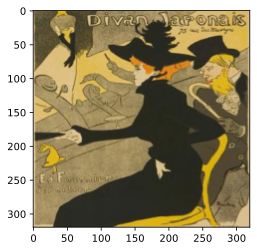

In [ ]:
# рисунки в картинах
for id in res_val_results[(res_val_results['check']==False)&(res_val_results['category_new']=='drawing')&(res_val_results['category_new_pridict']=='painting')]['id'].sample(3).to_list():
  try:
    name = path_res + id + '.jpg'
  
    img = Image.open(name)
    plt.imshow(img)
    plt.show()

    img.close()
  except: continue

Книжные иллюстрации, рисунки на цветной бумаге, яркие афиши (постеры).

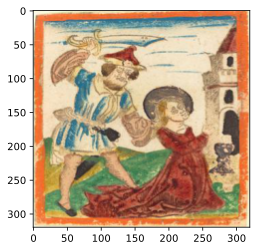

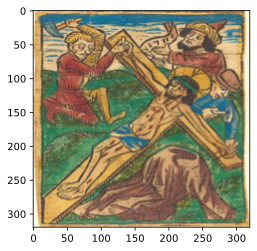

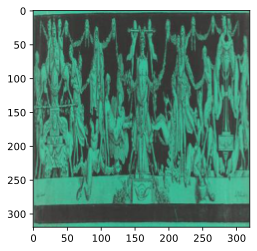

In [ ]:
# гравюры в картинах
for id in res_val_results[(res_val_results['check']==False)&(res_val_results['category_new']=='engraving')&(res_val_results['category_new_pridict']=='painting')]['id'].sample(3).to_list():
  try:
    name = path_res + id + '.jpg'
  
    img = Image.open(name)
    plt.imshow(img)
    plt.show()

    img.close()
  except: continue

Раскрашенные или же очень "плотные" гравюры.

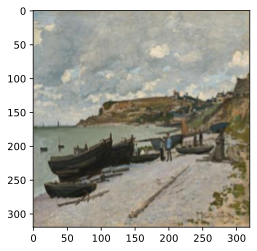

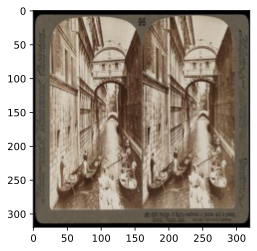

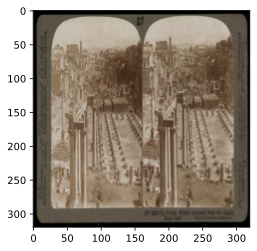

In [ ]:
# фотографии в картинах
for id in res_val_results[(res_val_results['check']==False)&(res_val_results['category_new']=='photography')&(res_val_results['category_new_pridict']=='painting')]['id'].sample(3).to_list():
  try:
    name = path_res + id + '.jpg'
  
    img = Image.open(name)
    plt.imshow(img)
    plt.show()

    img.close()
  except: continue

Композиционно фотографии действительно похожи на картины. Странно что модель не приняла во внимание отсутствие цвета. Хотя есть примеры раскрашенной фотографии.

### conv_model_slice_crop

Эта модель нужна для определения техники создания произведения: четкости линий, контрастности цветов.

(только кроп из середины - без аугментации):
- Adam(0.005)
- patience=5
- epochs = 10
- batch(100)

- CLASS_NUM activation='softmax'
- loss='categorical_crossentropy'

- best_model: 9
- val_accuracy: 68.70%

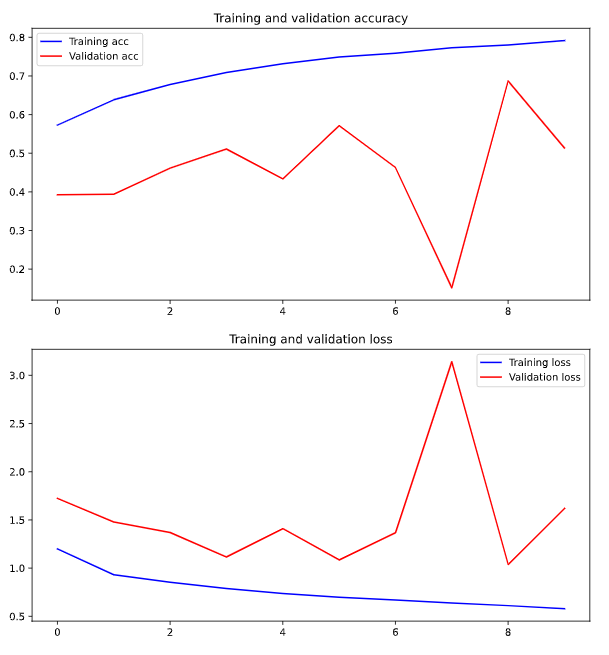

Обучение идет, но более скачкообразно. Есть смысл уменьшить скорость обучения. На форме кривой также сказывается подход к созданию датасета - кроп из середины оригинального изображения - это крайне разнородная информация.

Для данной модели предполагается аугментация: нарезка оригинальных картинок на кусочки. Сейчас для обучения использовался только кроп из середины. Это определенно ухудшает предсказательные возможности модели.

In [ ]:
crop_val_results = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Artsy_images/crop_val_results_total_softmax.csv')
round(crop_val_results.groupby(['check'])['id'].count()[1]/crop_val_results['id'].count()*100, 2)

68.7

In [ ]:
# посмотрим количество правдиво и ложно угаданных картинок
crop_val_results.groupby(['check'])['id'].count()

check
False    1058
True     2322
Name: id, dtype: int64

In [ ]:
# посмотрим количество правдиво и ложно угаданных категорий
crop_val_results.groupby(['category_new', 'check'])['id'].count()

category_new            check
drawing                 False     142
                        True     1182
engraving               False     514
                        True      816
gouache and watercolor  False     166
painting                False     112
                        True      297
photography             False     124
                        True       27
Name: id, dtype: int64

Модель совсем не смогла определить как класс гуаши с акварелями. В отличие от предыдущей смогла определить небольшое количество фотографий. А вот гравюры и картины определяет хуже.

In [ ]:
# посмотрим с чем модель путает неправильно угаданные категории
crop_val_results[crop_val_results['check']==False].groupby(['category_new', 'category_new_pridict'])['id'].count()

category_new            category_new_pridict
drawing                 engraving                71
                        painting                 65
                        photography               6
engraving               drawing                 490
                        painting                 24
gouache and watercolor  drawing                 130
                        engraving                 5
                        painting                 29
                        photography               2
painting                drawing                 103
                        engraving                 3
                        photography               6
photography             drawing                  73
                        engraving                 4
                        painting                 47
Name: id, dtype: int64

1. Гравюры часто определяются как рисунки, хотя данная модель должна была учитывать четкость линий.
2. Фотографии даже по нижнеуровневым признакам схожа с рисунком - черно-белые с размытыми контурами.
3. Гуашь и акварель часто являются раскрашенными рисунками. Гуашь - достаточно плотная краска, это создает риск ее определения в картины.
4. Посмотрим, что это за картины, которые определяются как рисунки.

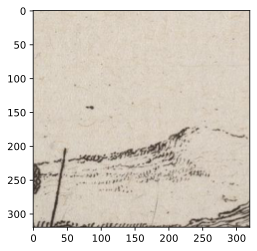

Пример кусочка


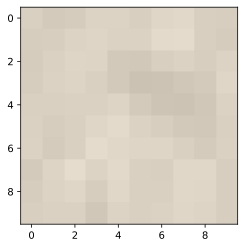

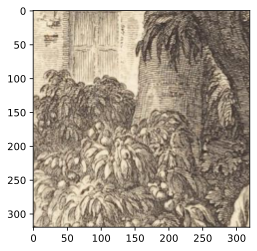

Пример кусочка


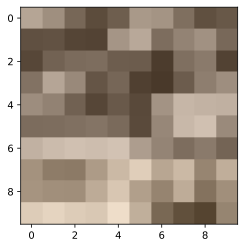

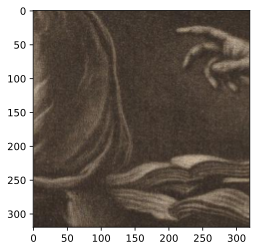

Пример кусочка


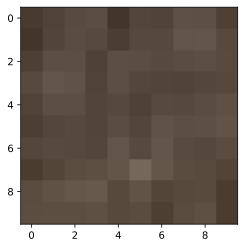

In [ ]:
# гравюры в рисунках
for id in crop_val_results[(crop_val_results['check']==False)&(crop_val_results['category_new']=='engraving')&(crop_val_results['category_new_pridict']=='drawing')]['id'].sample(3).to_list():
  try:
    name = path_crop + id + '.jpg'
  
    img = Image.open(name)
    plt.imshow(img)
    plt.show()

    #   The coordinates for the box are (left, upper, right, lower)
    box = (100, 105, 110, 115)
    crop_img = img.crop(box)
    print('Пример кусочка')
    plt.imshow(crop_img)
    plt.show()

    img.close()
  except: continue

Качество бумаги и плотность штриховки гравюр мешают модели корректно определить их класс.

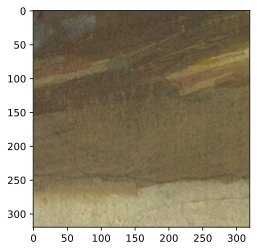

Пример кусочка


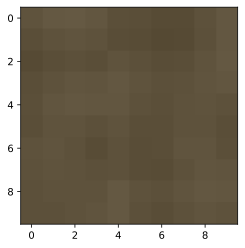

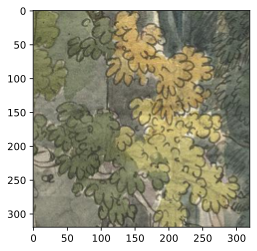

Пример кусочка


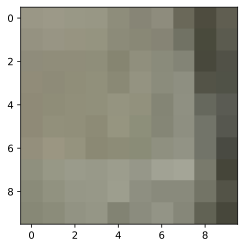

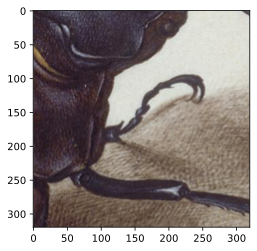

Пример кусочка


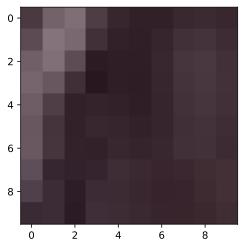

In [ ]:
# гуашь и акварель в картинах
for id in crop_val_results[(crop_val_results['check']==False)&(crop_val_results['category_new']=='gouache and watercolor')&(crop_val_results['category_new_pridict']=='painting')]['id'].sample(3).to_list():
  try:
    name = path_crop + id + '.jpg'
  
    img = Image.open(name)
    plt.imshow(img)
    plt.show()

    #   The coordinates for the box are (left, upper, right, lower)
    box = (100, 105, 110, 115)
    crop_img = img.crop(box)
    print('Пример кусочка')
    plt.imshow(crop_img)
    plt.show()

    img.close()
  except: continue

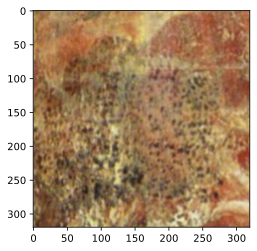

Пример кусочка


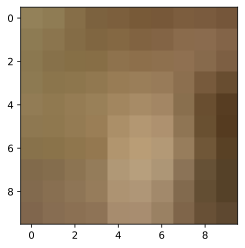

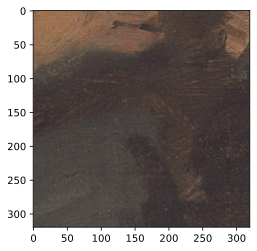

Пример кусочка


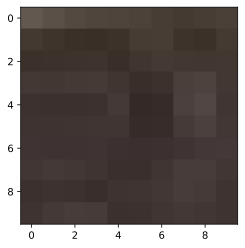

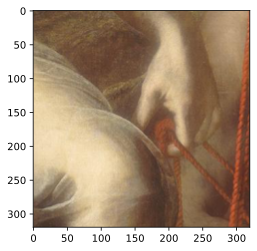

Пример кусочка


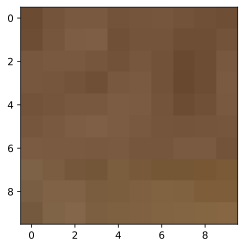

In [ ]:
# картины в рисунках
for id in crop_val_results[(crop_val_results['check']==False)&(crop_val_results['category_new']=='painting')&(crop_val_results['category_new_pridict']=='drawing')]['id'].sample(3).to_list():
  try:
    name = path_crop + id + '.jpg'
  
    img = Image.open(name)
    plt.imshow(img)
    plt.show()

    #   The coordinates for the box are (left, upper, right, lower)
    box = (100, 105, 110, 115)
    crop_img = img.crop(box)
    print('Пример кусочка')
    plt.imshow(crop_img)
    plt.show()

    img.close()
  except: continue

Кусочки, в которых преобладают черные, серые и бежевые оттенки.

### transfer learning

EfficientNetB6

weights='imagenet'

- Adam(0.001 -> 0.0001)
- patience=5
- epochs = 10
- batch(10)

- CLASS_NUM activation='softmax'
- loss='categorical_crossentropy'

- best_model: 9
- val_accuracy: 87.84%

Обучение проходило в 3 этапа:
- только головы;
- разморозка половины весов;
- разморозка 100% весов

Обучение началось с первого же этапа. Линии хоть и были расположены далеко друг от друга, но начали сходиться.

После разморозки половины весов расстояние между линиями значительно сократилось.

Разморозка 100% весов улучшила результат, но появился риск переобучения.

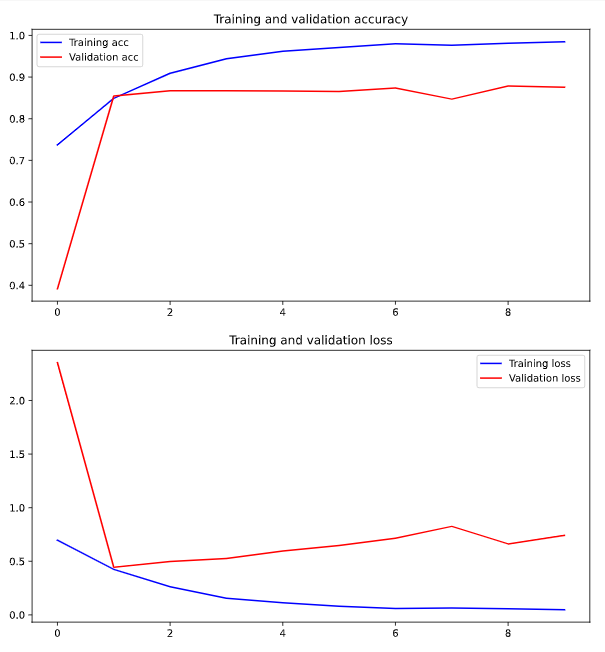

In [ ]:
tl_val_results = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Artsy_images/tl_val_results_total_softmax.csv')
round(tl_val_results.groupby(['check'])['id'].count()[1]/tl_val_results['id'].count()*100, 2)

87.84

In [ ]:
# посмотрим количество правдиво и ложно угаданных картинок
tl_val_results.groupby(['check'])['id'].count()

check
False     411
True     2969
Name: id, dtype: int64

In [ ]:
# посмотрим количество правдиво и ложно угаданных категорий
tl_val_results.groupby(['category_new', 'check'])['id'].count()

category_new            check
drawing                 False     143
                        True     1181
engraving               False      97
                        True     1233
gouache and watercolor  False      58
                        True      108
painting                False      63
                        True      346
photography             False      50
                        True      101
Name: id, dtype: int64

EfficientNetB6 неплохо справилась даже с фотографиями и гуашами с акварелью.

In [ ]:
# посмотрим с чем модель путает неправильно угаданные категории
tl_val_results[tl_val_results['check']==False].groupby(['category_new', 'category_new_pridict'])['id'].count()

category_new            category_new_pridict  
drawing                 engraving                 84
                        gouache and watercolor    30
                        painting                  13
                        photography               16
engraving               drawing                   84
                        gouache and watercolor    10
                        photography                3
gouache and watercolor  drawing                   34
                        engraving                 11
                        painting                   9
                        photography                4
painting                drawing                   16
                        engraving                  2
                        gouache and watercolor    12
                        photography               33
photography             drawing                    8
                        engraving                  5
                        painting                  37

Но и дерево ошибок у нее оказалось более разветвленное.

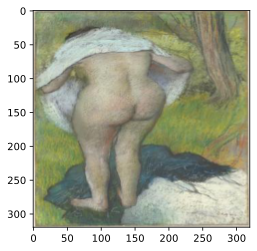

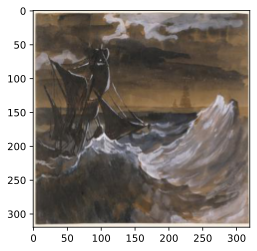

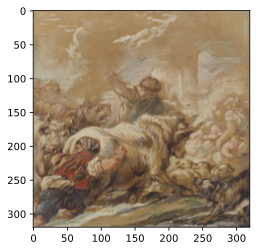

In [ ]:
# рисунки в гуашах и акварелях
for id in tl_val_results[(tl_val_results['check']==False)&(tl_val_results['category_new']=='drawing')&(tl_val_results['category_new_pridict']=='gouache and watercolor')]['id'].sample(3).to_list():
  try:
    name = path_res + id + '.jpg'
  
    img = Image.open(name)
    plt.imshow(img)
    plt.show()

    img.close()
  except: continue

На самом деле, почему бы и нет. Вопрос к качеству датасета.

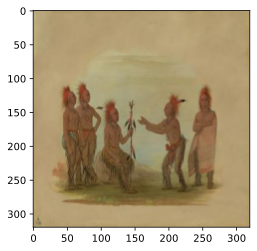

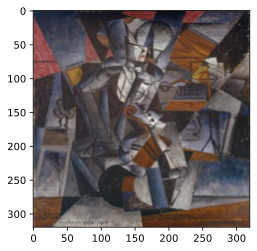

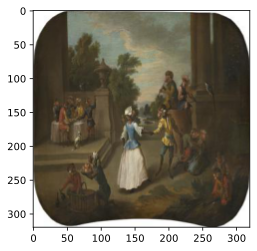

In [ ]:
# картины в гуашах и акварелях
for id in tl_val_results[(tl_val_results['check']==False)&(tl_val_results['category_new']=='painting')&(tl_val_results['category_new_pridict']=='gouache and watercolor')]['id'].sample(3).to_list():
  try:
    name = path_res + id + '.jpg'
  
    img = Image.open(name)
    plt.imshow(img)
    plt.show()

    img.close()
  except: continue

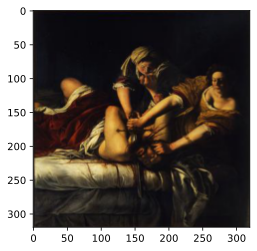

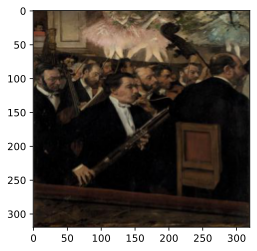

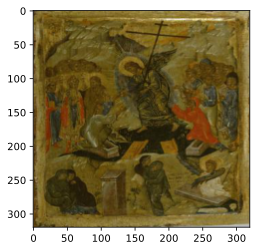

In [ ]:
# картины в фоторгафиях
for id in tl_val_results[(tl_val_results['check']==False)&(tl_val_results['category_new']=='painting')&(tl_val_results['category_new_pridict']=='photography')]['id'].sample(3).to_list():
  try:
    name = path_res + id + '.jpg'
  
    img = Image.open(name)
    plt.imshow(img)
    plt.show()

    img.close()
  except: continue

### кроссчек моделей

In [ ]:
res_val_results.columns

Index(['id', 'cat', 'cat_predict', 'category_new', 'category_new_pridict',
       'check'],
      dtype='object')

In [ ]:
res_val_results_check = res_val_results[['id', 'category_new', 'category_new_pridict', 'check']]

In [ ]:
res_val_results_check.columns = ['id', 'category_new', 'category_new_pridict_res', 'check_res']

In [ ]:
crop_val_results.columns

Index(['id', 'cat', 'cat_predict', 'category_new', 'category_new_pridict',
       'check'],
      dtype='object')

In [ ]:
crop_val_results_check = crop_val_results[['id', 'category_new', 'category_new_pridict', 'check']]
crop_val_results_check.columns = ['id', 'category_new', 'category_new_pridict_crop', 'check_crop']
crop_val_results_check.head()

id  ... check_crop
0  516cac3eb83d23b4db000b80  ...       True
1  515b148e9562c86fb800095d  ...       True
2  515d5083769659e1fb004235  ...      False
3  515b4ad2223afaab8f0014da  ...       True
4  516df517b31e2b22700009f2  ...      False

[5 rows x 4 columns]

In [ ]:
tl_val_results.columns

Index(['id', 'cat', 'cat_predict', 'category_new', 'category_new_pridict',
       'check'],
      dtype='object')

In [ ]:
tl_val_results_check = tl_val_results[['id', 'category_new', 'category_new_pridict', 'check']]
tl_val_results_check.columns = ['id', 'category_new', 'category_new_pridict_tl', 'check_tl']
tl_val_results_check.head()

id  ... check_tl
0  516cac3eb83d23b4db000b80  ...     True
1  515b148e9562c86fb800095d  ...     True
2  515d5083769659e1fb004235  ...     True
3  515b4ad2223afaab8f0014da  ...     True
4  516df517b31e2b22700009f2  ...     True

[5 rows x 4 columns]

In [ ]:
results_check = res_val_results_check.merge(crop_val_results_check, on='id', how='left').merge(tl_val_results_check, on='id', how='left')

In [ ]:
results_check = results_check.drop(['category_new_x', 'category_new_y'], axis=1)

In [ ]:
results_check.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3380 entries, 0 to 3379
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   id                         3380 non-null   object
 1   category_new_pridict_res   3380 non-null   object
 2   check_res                  3380 non-null   bool  
 3   category_new_pridict_crop  3380 non-null   object
 4   check_crop                 3380 non-null   bool  
 5   category_new               3380 non-null   object
 6   category_new_pridict_tl    3380 non-null   object
 7   check_tl                   3380 non-null   bool  
dtypes: bool(3), object(5)
memory usage: 168.3+ KB


In [ ]:
# посмотрим какие классы смогла определить модель, обученная на целых картинках, а на кропах нет
results_check[(results_check['check_res']==True)&(results_check['check_crop']==False)].groupby(['category_new', 'category_new_pridict_crop'])['id'].count()

category_new  category_new_pridict_crop
drawing       engraving                     40
              painting                      41
              photography                    3
engraving     drawing                      317
              painting                      10
painting      drawing                       94
              engraving                      2
              photography                    6
Name: id, dtype: int64

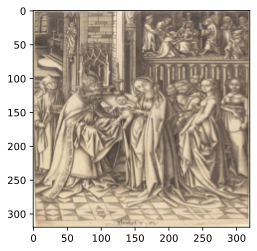

Пример кусочка


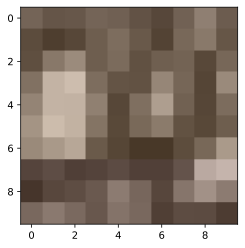

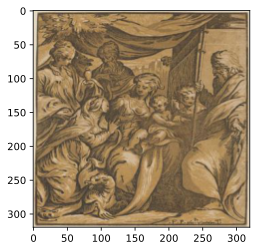

Пример кусочка


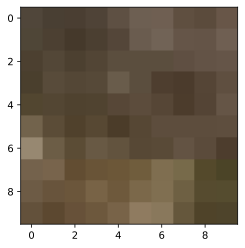

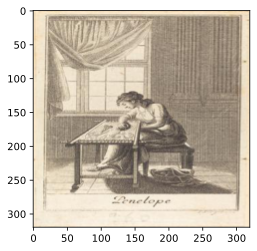

Пример кусочка


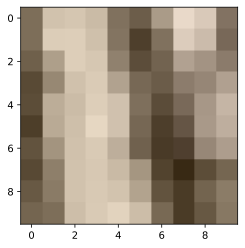

In [ ]:
# гравюры в рисунках
for id in results_check[(results_check['check_res']==True)&(results_check['check_crop']==False)&(results_check['category_new']=='engraving')&(results_check['category_new_pridict_crop']=='drawing')]['id'].sample(3).to_list():
  try:
    name_res = path_res + id + '.jpg'
    img_res = Image.open(name_res)
    plt.imshow(img_res)
    plt.show()

    img_res.close()

    name_crop = path_crop + id + '.jpg'
    img_crop = Image.open(name_crop)
    #   The coordinates for the box are (left, upper, right, lower)
    box = (100, 105, 110, 115)
    crop_img = img_crop.crop(box)
    print('Пример кусочка')
    plt.imshow(crop_img)
    plt.show()

    img_crop.close()
  except: continue

Плотные и раскрашенные гравюры. Хотя на последней линии более-менее четкие...

In [ ]:
# посмотрим какие классы смогла определить модель, обученная на кропах, а на целых картинках нет
results_check[(results_check['check_crop']==True)&(results_check['check_res']==False)].groupby(['category_new', 'category_new_pridict_res'])['id'].count()

category_new  category_new_pridict_res
drawing       engraving                   153
              painting                     26
engraving     drawing                     141
painting      drawing                      11
photography   drawing                       8
              engraving                     2
              painting                     17
Name: id, dtype: int64

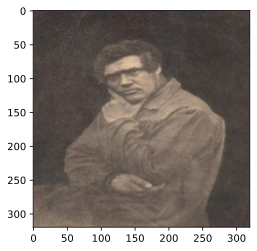

Пример кусочка


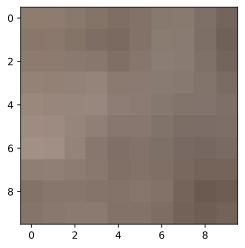

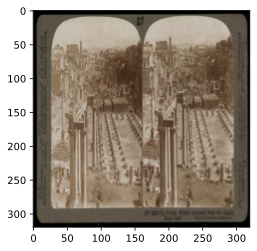

Пример кусочка


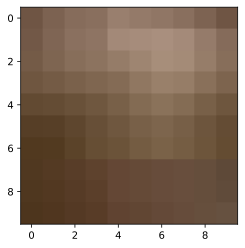

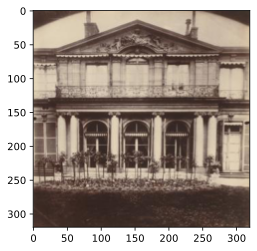

Пример кусочка


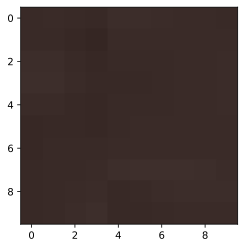

In [ ]:
# фотографии в картинах
for id in results_check[(results_check['check_crop']==True)&(results_check['check_res']==False)&(results_check['category_new']=='photography')&(results_check['category_new_pridict_res']=='painting')]['id'].sample(3).to_list():
  try:
    name_res = path_res + id + '.jpg'
    img_res = Image.open(name_res)
    plt.imshow(img_res)
    plt.show()

    img_res.close()

    name_crop = path_crop + id + '.jpg'
    img_crop = Image.open(name_crop)
    #   The coordinates for the box are (left, upper, right, lower)
    box = (100, 105, 110, 115)
    crop_img = img_crop.crop(box)
    print('Пример кусочка')
    plt.imshow(crop_img)
    plt.show()

    img_crop.close()
  except: continue

Четко просматривается градиент позволил второй модели определить фотографию.

In [ ]:
# посмотрим какие классы не смогла определить предобученная модель, а другие смогли
results_check[(results_check['check_tl']==False)&(results_check['check_res']==True)&(results_check['check_crop']==True)].groupby(['category_new', 'category_new_pridict_tl'])['id'].count()

category_new  category_new_pridict_tl
drawing       engraving                  24
              gouache and watercolor     16
              photography                 6
engraving     drawing                    12
              gouache and watercolor      4
painting      drawing                    11
              engraving                   1
              gouache and watercolor      5
              photography                19
Name: id, dtype: int64

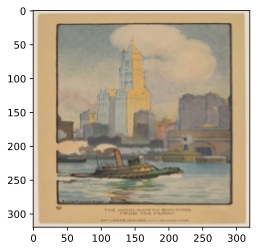

Пример кусочка


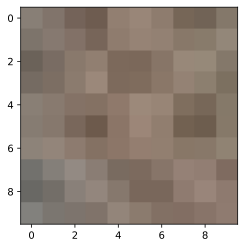

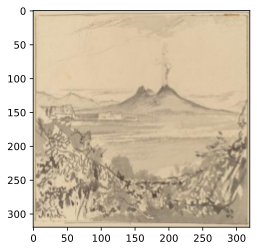

Пример кусочка


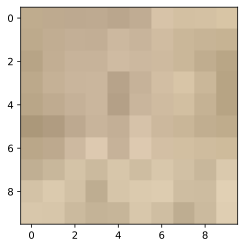

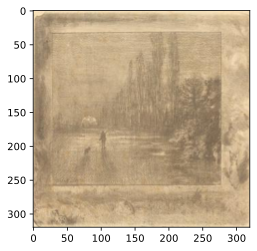

Пример кусочка


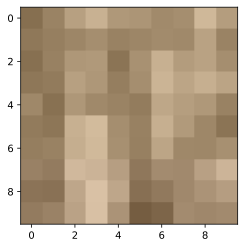

In [ ]:
# рисунки в гравюрах
for id in results_check[(results_check['check_tl']==False)&(results_check['check_res']==True)&(results_check['check_crop']==True)&(results_check['category_new']=='drawing')&(results_check['category_new_pridict_tl']=='engraving')]['id'].sample(3).to_list():
  try:
    name_res = path_res + id + '.jpg'
    img_res = Image.open(name_res)
    plt.imshow(img_res)
    plt.show()

    img_res.close()

    name_crop = path_crop + id + '.jpg'
    img_crop = Image.open(name_crop)
    #   The coordinates for the box are (left, upper, right, lower)
    box = (100, 105, 110, 115)
    crop_img = img_crop.crop(box)
    print('Пример кусочка')
    plt.imshow(crop_img)
    plt.show()

    img_crop.close()
  except: continue

Выводы:
1. С одной стороны, нужно углублять модели, расширять обучающие датасеты аугментацией. Или же подбирать и настраивать наиболее подходящие модели для transfer learning.
2. С другой, упрощать (обобщать) сами данные. 

- Например, с помощью локализации и сегментации определять местонахождение и количество разных объектов на изображении. Для рисунков, например, характерно небольшое количество объектов и много пустого пространства вокруг него. 
- Или собрать информацию о количестве цветов и их расположение на градиенте. Для картин, например, характерно наличие большого количества цветов, и они тяготеют к темной части спектра из-за плотности краски.
- Но все это, конечно, не всегда работает.